In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.core.initial_designs.random_design import RandomDesign
from chimera import Chimera
from emukit.core.loop.user_function import UserFunctionWrapper
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import plotly.express as px
import plotly.graph_objects as go
from numpy.linalg import norm
import os
import scipy.stats
import math

In [2]:
MACl_min, MACl_max, MACl_step = [0, 30, 5] ## Unit: %, 7 steps
MACl_var = np.arange(MACl_min, MACl_max+MACl_step*0.1, MACl_step)
MACl_num = len(MACl_var)

DMF_min, DMF_max, DMF_step = [0, 90, 5] ## Unit: %, 19 steps
DMF_var = np.arange(DMF_min, DMF_max+DMF_step*0.1, DMF_step)
DMF_num = len(DMF_var)

V_min, V_max, V_step = [15, 30, 0.5] ## Unit: KV, 31 steps
V_var = np.arange(V_min, V_max+V_step*0.1, V_step)
V_num = len(V_var)

Q_min, Q_max, Q_step = [0.7, 1.7, 0.05] ## Unit: μL/min, # 21 steps
Q_var = np.arange(Q_min, Q_max+Q_step*0.1, Q_step)
Q_num = len(Q_var)

T_min, T_max, T_step = [100, 150, 5] ## Unit: ℃, # 11 steps
T_var = np.arange(T_min, T_max+T_step*0.1, T_step)
T_num = len(T_var)

t_min, t_max, t_step = [10, 30, 5] ## Unit: min, # 5 steps
t_var = np.arange(t_min, t_max+t_step*0.1, t_step)
t_num = len(t_var)


var_array = [MACl_var, DMF_var, 
             V_var, Q_var,
            T_var,t_var]

x_labels = ['MACl [%]', 
            'DMF [%]', 
            'V [KV]', 
            'Q [uL/min]',
            'T [degC]',
            't [min]']    

In [3]:
def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)

def get_closest_value(given_value, array_list):
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    closest_value = min(array_list, key=absolute_difference_function)
    return closest_value
    
def get_closest_array(suggested_x, var_list):
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
X_all_grid = []
for MACl in MACl_var:
    for DMF in DMF_var:
        for V in V_var:
            for Q in Q_var:
                for T in T_var:
                    for t in t_var:
                        X_all_grid.append([MACl, DMF, V, Q, T,t])
X_all_grid = np.array(X_all_grid)
X_all_grid.shape

(4762065, 6)

In [5]:
x_eva=x_normalizer(X_all_grid)

In [6]:
### Add/minus a half step to make sure the edge conditions have the same chance in nearest neighbors
parameter_space = ParameterSpace([ContinuousParameter('x1', 0-1/(MACl_num-1)/2, 1+1/(MACl_num-1)/2),
                                  ContinuousParameter('x2', 0-1/(DMF_num-1)/2,  1+1/(DMF_num-1)/2),
                                  ContinuousParameter('x3', 0-1/(V_num-1)/2,    1+1/(V_num-1)/2),
                                  ContinuousParameter('x4', 0-1/(Q_num-1)/2,    1+1/(Q_num-1)/2),
                                  ContinuousParameter('x5', 0-1/(T_num-1)/2,    1+1/(T_num-1)/2),
                                  ContinuousParameter('x6', 0-1/(t_num-1)/2,    1+1/(t_num-1)/2)])

In [17]:
df_test = pd.read_csv('./data_1st.csv')
df_test

ML Condition  MACl [%]  DMF [%]  V [KV]  Q [uL/min]  T [degC]  t [min]  \
0              0         5       70    28.5        1.15       105       10   
1              1         5       20    19.5        1.25       130       25   
2              2        15        5    29.5        1.05       140       15   
3              3        20        0    24.5        0.90       150       20   
4              4        10       25    23.5        0.80       125       25   
5              5        10       85    20.5        1.40       115       20   
6              6         0       60    16.5        1.00       110       15   
7              7        25       30    27.5        1.35       120       25   
8              8        15       75    18.5        0.85       105       10   
9              9        20       15    22.5        1.50       100       15   
10            10         0       90    25.5        1.70       120       10   
11            11        15       50    26.5        0.70       135       20   

    Film Quality   XRD  PL_std   TRPL  
0              1  1.85    6.09  14.74  
1              1  0.95     NaN    NaN  
2              1  0.16     NaN    NaN  
3              1  0.28     NaN    NaN  
4              1  1.06    2.52  63.93  
5              0   NaN     NaN    NaN  
6              0   NaN     NaN    NaN  
7              1  0.23    1.74  71.79  
8              0   NaN     NaN    NaN  
9              1  0.48     NaN    NaN  
10             1  0.18    1.83  89.50  
11             1  0.16     NaN    NaN

In [18]:
x1=df_test.iloc[:,1:7].values#process conditions
idx2=np.array([0,1,2,3,4,7,10,11])
idx3=np.array([0,4,7,10])
x2=x1[idx2]
x3=x1[idx3]
x1=x_normalizer(x1)
x2=x_normalizer(x2)
x3=x_normalizer(x3)
y1=np.transpose([df_test.iloc[:,-4].values])#Film Quality
y2=np.transpose([df_test.iloc[:,-3].values])#XRD(PbI:PVK)
y2=y2[idx2]
y3=np.transpose([df_test.iloc[:,-3].values])#PL_std
y4=np.transpose([df_test.iloc[:,-1].values])#TRPL
y3=y3[idx3]
y4=y4[idx3]

In [19]:
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
X1, Y1 = [x1, y1]
X2, Y2 = [x2, y2]
X3, Y3 = [x3, y3]
X4, Y4 = [x3, y4]

input_dim = len(X1[0])
ker1 = GPy.kern.RBF(input_dim = input_dim, ARD =True)
ker1.lengthscale.constrain_bounded(1e-2, 10)
ker1.variance.constrain_bounded(1e-1, 1e4)
model1_gpy = GPRegression(X1, -Y1, ker1)#Emukit is a minimization tool; need to make Y negative
model1_gpy.randomize()
model1_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model1 = GPyModelWrapper(model1_gpy)
print(objective_model1.model.kern.lengthscale)
print(objective_model1.model.kern.variance)

input_dim = len(X2[0])
ker2 = GPy.kern.Matern52(input_dim = input_dim, ARD =True)
ker2.lengthscale.constrain_bounded(1e-2, 10)
ker2.variance.constrain_bounded(1e-1, 1e4)
model2_gpy = GPRegression(X2, Y2-0.5, ker2)#constraint acquisition computes the probability of < 0.5
model2_gpy.Gaussian_noise.variance =0.05**2
model2_gpy.Gaussian_noise.variance.fix()
model2_gpy.randomize()
model2_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model2 = GPyModelWrapper(model2_gpy)
print(objective_model2.model.kern.lengthscale)
print(objective_model2.model.kern.variance)

input_dim = len(X3[0])
ker3 = GPy.kern.Matern52(input_dim = input_dim, ARD =True)
ker3.lengthscale.constrain_bounded(1e-2, 10)
ker3.variance.constrain_bounded(1e-1, 1e4)
model3_gpy = GPRegression(X3, Y3, ker3)
model3_gpy.Gaussian_noise.variance =0.2**2
model3_gpy.Gaussian_noise.variance.fix()
model3_gpy.randomize()
model3_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model3 = GPyModelWrapper(model3_gpy)
print(objective_model3.model.kern.lengthscale)
print(objective_model3.model.kern.variance)

input_dim = len(X4[0])
ker4 = GPy.kern.Matern52(input_dim = input_dim, ARD =True)
ker4.lengthscale.constrain_bounded(1e-2, 10)
ker4.variance.constrain_bounded(1e-1, 1e4)
model4_gpy = GPRegression(X4, -Y4, ker4)#Emukit is a minimization tool; need to make Y negative
model4_gpy.Gaussian_noise.variance =10**2
model4_gpy.Gaussian_noise.variance.fix()
model4_gpy.randomize()
model4_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model4 = GPyModelWrapper(model4_gpy)
print(objective_model4.model.kern.lengthscale)
print(objective_model4.model.kern.variance)

f_obj1 =  objective_model1.model.predict
f_obj2 =  objective_model2.model.predict
f_obj3 =  objective_model3.model.predict
f_obj4 =  objective_model4.model.predict

y1_pred, y1_uncer = f_obj1(X1)
y1_pred = -y1_pred[:,-1]
y2_pred, y2_uncer = f_obj2(X2)
y2_pred = y2_pred[:,-1]+0.5
y3_pred, y3_uncer = f_obj3(X3)
y3_pred = y3_pred[:,-1]
y4_pred, y4_uncer = f_obj4(X4)
y4_pred = -y4_pred[:,-1]
y1_uncer = np.sqrt(y1_uncer[:,-1])
y2_uncer = np.sqrt(y2_uncer[:,-1])
y3_uncer = np.sqrt(y3_uncer[:,-1])
y4_uncer = np.sqrt(y4_uncer[:,-1])

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     9.99999950  |   0.01,10.0   |        
  [1]    |                     0.77029615  |   0.01,10.0   |        
  [2]    |                     0.33333949  |   0.01,10.0   |        
  [3]    |                    10.00000000  |   0.01,10.0   |        
  [4]    |                    10.00000000  |   0.01,10.0   |        
  [5]    |                    10.00000000  |   0.01,10.0   |        
  index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |                  0.49580365  |  0.1,10000.0  |        


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                      10.00000000  |   0.01,10.0   |        
  [1]    |                       9.99999997  |   0.01,10.0   |        
  [2]    |                      10.00000000  |   0.01,10.0   |        
  [3]    |                      10.00000000  |   0.01,10.0   |        
  [4]    |                       0.10668431  |   0.01,10.0   |        
  [5]    |                       9.99962970  |   0.01,10.0   |        
  index  |  GP_regression.Mat52.variance  |  constraints  |  priors
  [0]    |                    0.41035776  |  0.1,10000.0  |        


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                      10.00000000  |   0.01,10.0   |        
  [1]    |                      10.00000000  |   0.01,10.0   |        
  [2]    |                       9.99997032  |   0.01,10.0   |        
  [3]    |                      10.00000000  |   0.01,10.0   |        
  [4]    |                       0.11482910  |   0.01,10.0   |        
  [5]    |                      10.00000000  |   0.01,10.0   |        
  index  |  GP_regression.Mat52.variance  |  constraints  |  priors
  [0]    |                    1.41019225  |  0.1,10000.0  |        
  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       9.99999998  |   0.01,10.0   |        
  [1]    |                       6.19385315  |   0.01,10.0   |        
  [2]    |                      10.00000000  |   0.01,10.0   |        
  [3]    |                       6.12054895  |   0.01,10.0   |        
  [4]    |  

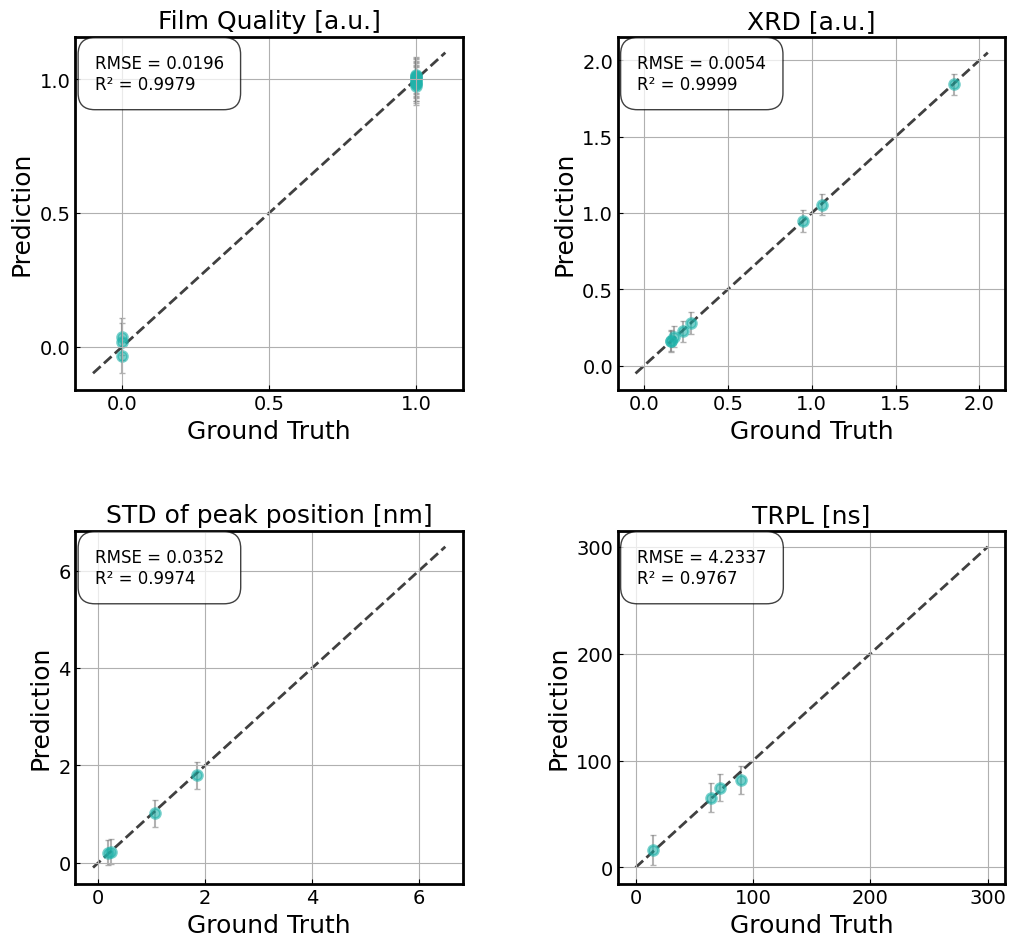

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 11))
fs = 18

linewidth = 2
scatter_size = 50 

lims1 = (-.1, 1.1)
scatter1 = axes[0, 0].scatter(Y1[:,-1], y1_pred, alpha = 0.6, c = 'lightseagreen', s=scatter_size, linewidth=linewidth)
axes[0, 0].errorbar(Y1[:,-1], y1_pred, yerr = y1_uncer, ms = 0, ls = '', capsize = 2, alpha = 0.6, color = 'gray', zorder = 0)
axes[0, 0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0, linewidth=linewidth)
rmse_value = np.sqrt(mean_squared_error(Y1[:,-1], y1_pred))
rsquared_xrd = r2_score(Y1[:,-1], y1_pred)

textstr1 = f'RMSE = {rmse_value:.4f}\nR² = {rsquared_xrd:.4f}'
axes[0, 0].text(0.05, 0.95, textstr1, transform=axes[0, 0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.75, edgecolor='black', boxstyle='round,pad=1'))

axes[0, 0].set_xlabel('Ground Truth', fontsize = fs)
axes[0, 0].set_ylabel('Prediction', fontsize = fs)
axes[0, 0].set_title('Film Quality [a.u.]', fontsize = fs)
axes[0, 0].tick_params(axis='both', labelsize=14, direction='in')  
axes[0, 0].grid(True)  

for spine in axes[0, 0].spines.values():
    spine.set_linewidth(2)

axes[0, 0].set_xticks([0, 0.5, 1.0])
axes[0, 0].set_yticks([0, 0.5, 1.0])

lims2 = (-.05, 2.05)
scatter2 = axes[0, 1].scatter(Y2[:,-1], y2_pred, alpha = 0.6, c = 'lightseagreen', s=scatter_size, linewidth=linewidth)
axes[0, 1].errorbar(Y2[:,-1], y2_pred, yerr = y2_uncer, ms = 0, ls = '', capsize = 2, alpha = 0.6, color = 'gray', zorder = 0)
axes[0, 1].plot(lims2, lims2, 'k--', alpha=0.75, zorder=0, linewidth=linewidth)
rmse_value = np.sqrt(mean_squared_error(Y2[:,-1], y2_pred))
rsquared_trpl = r2_score(Y2[:,-1], y2_pred)

textstr2 = f'RMSE = {rmse_value:.4f}\nR² = {rsquared_trpl:.4f}'
axes[0, 1].text(0.05, 0.95, textstr2, transform=axes[0, 1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.75, edgecolor='black', boxstyle='round,pad=1'))

axes[0, 1].set_xlabel('Ground Truth', fontsize = fs)
axes[0, 1].set_ylabel('Prediction', fontsize = fs)
axes[0, 1].set_title('XRD [a.u.]', fontsize = fs)
axes[0, 1].tick_params(axis='both', labelsize=14, direction='in')
axes[0, 1].grid(True)  

for spine in axes[0, 1].spines.values():
    spine.set_linewidth(2)

axes[0, 1].set_xticks([0, 0.5, 1.0, 1.5, 2.0])
axes[0, 1].set_yticks([0, 0.5, 1.0, 1.5, 2.0])

lims3 = (-.1, 6.5)
scatter3 = axes[1, 0].scatter(Y3[:,-1], y3_pred, alpha = 0.6, c = 'lightseagreen', s=scatter_size, linewidth=linewidth)
axes[1, 0].errorbar(Y3[:,-1], y3_pred, yerr = y3_uncer, ms = 0, ls = '', capsize = 2, alpha = 0.6, color = 'gray', zorder = 0)
axes[1, 0].plot(lims3, lims3, 'k--', alpha=0.75, zorder=0, linewidth=linewidth)
rmse_value = np.sqrt(mean_squared_error(Y3[:,-1], y3_pred))
rsquared_pl = r2_score(Y3[:,-1], y3_pred)

textstr3 = f'RMSE = {rmse_value:.4f}\nR² = {rsquared_pl:.4f}'
axes[1, 0].text(0.05, 0.95, textstr3, transform=axes[1, 0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.75, edgecolor='black', boxstyle='round,pad=1'))

axes[1, 0].set_xlabel('Ground Truth', fontsize = fs)
axes[1, 0].set_ylabel('Prediction', fontsize = fs)
axes[1, 0].set_title('STD of peak position [nm]', fontsize = fs)
axes[1, 0].tick_params(axis='both', labelsize=14, direction='in')
axes[1, 0].grid(True)  

for spine in axes[1, 0].spines.values():
    spine.set_linewidth(2)

axes[1, 0].set_xticks([0, 2, 4, 6])
axes[1, 0].set_yticks([0, 2, 4, 6])

lims4 = (-.1,300.1)
scatter4 = axes[1, 1].scatter(Y4[:,-1], y4_pred, alpha = 0.6, c = 'lightseagreen', s=scatter_size, linewidth=linewidth)
axes[1, 1].errorbar(Y4[:,-1], y4_pred, yerr = y4_uncer, ms = 0, ls = '', capsize = 2, alpha = 0.6, color = 'gray', zorder = 0)
axes[1, 1].plot(lims4, lims4, 'k--', alpha=0.75, zorder=0, linewidth=linewidth)
rmse_value = np.sqrt(mean_squared_error(Y4[:,-1], y4_pred))
rsquared_film = r2_score(Y4[:,-1], y4_pred)

textstr4 =  f'RMSE = {rmse_value:.4f}\nR² = {rsquared_film:.4f}'
axes[1, 1].text(0.05, 0.95, textstr4, transform=axes[1, 1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.75, edgecolor='black', boxstyle='round,pad=1'))

axes[1, 1].set_xlabel('Ground Truth', fontsize = fs)
axes[1, 1].set_ylabel('Prediction', fontsize = fs)
axes[1, 1].set_title('TRPL [ns]', fontsize = fs)
axes[1, 1].tick_params(axis='both', labelsize=14, direction='in')
axes[1, 1].grid(True)


for spine in axes[1, 1].spines.values():
    spine.set_linewidth(2)

axes[1, 1].set_xticks([0, 100, 200, 300])
axes[1, 1].set_yticks([0, 100, 200, 300])

plt.subplots_adjust(wspace = 0.4, hspace=0.4)
plt.show()

In [29]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import NegativeLowerConfidenceBound,ProbabilityOfFeasibility,ProbabilityOfImprovement
acquisition1 = NegativeLowerConfidenceBound(objective_model4,beta = 1)
acquisition2 = NegativeLowerConfidenceBound(objective_model3,beta = 1)
acquisition_constraint = ProbabilityOfFeasibility(objective_model2)
obj1_plot = -acquisition1.evaluate(x_eva)
obj2_plot = -acquisition2.evaluate(x_eva)
cons_plot = acquisition_constraint.evaluate(x_eva)

tolerances = np.array([-99,1.97]) 
absolutes = [True, True]
goals = ['min', 'min'] 
chimera = Chimera(tolerances=tolerances, absolutes=absolutes, goals=goals)
obj = np.array([obj1_plot.T[0], obj2_plot.T[0]])
scalarized = chimera.scalarize(obj.T)
cons_acq = (1-scalarized)*cons_plot.T[0]#constrained acquisition

In [30]:
np.random.seed(10) # to make sure the random results is reproducible 
bs=10
sort_index = np.argsort(cons_acq, axis =0)
X_new = []
top = 47620 # top 1% = 47620/4762065 You should set it according to your confidence in the model (balance of exploitation and exploration)
for i in sort_index[-top:]:
        X_new.append(X_all_grid[i])
X_new=np.array(X_new)
bs_index = [np.random.randint(top) for i in np.arange(bs)]
X_new = X_new[bs_index]
# acq_new1 = acquisition1.evaluate(x_normalizer(X_new))
# acq_new2 = acquisition2.evaluate(x_normalizer(X_new))
cons_pr = acquisition_constraint.evaluate(x_normalizer(X_new))
idx=sort_index[-top:][bs_index]
final_acq=cons_acq[idx]
y_new_pred1, y_new_uncer1 = f_obj4(x_normalizer(X_new))
y_new_pred2, y_new_uncer2 = f_obj3(x_normalizer(X_new))
df_Xnew = pd.DataFrame(X_new, columns = x_labels)
df_all = pd.concat([df_test.iloc[:,1:7], df_Xnew])
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[len(df_test):len(df_test)+bs]
df_Xnew = df_Xnew.sort_values(by=list(df_test.columns[1:7]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df_test)
print('New X:',len(df_Xnew))
df_Xnew

New X: 10


MACl [%]  DMF [%]  V [KV]  Q [uL/min]  T [degC]  t [min]
12       0.0     30.0    27.5        1.70     115.0     15.0
13       0.0     35.0    21.5        1.60     115.0     15.0
14      15.0      0.0    21.0        0.80     140.0     15.0
15      15.0     10.0    19.0        0.95     145.0     15.0
16      15.0     10.0    23.5        1.40     145.0     15.0
17      15.0     15.0    27.0        1.50     145.0     15.0
18      20.0      0.0    16.5        1.10     150.0     15.0
19      20.0     20.0    20.0        0.70     150.0     15.0
20      20.0     20.0    29.0        1.60     145.0     15.0
21      25.0      5.0    23.5        0.85     115.0     15.0

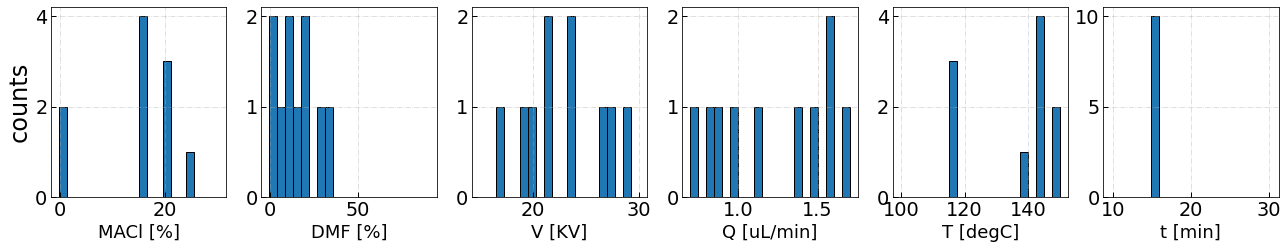

In [31]:
df_x = df_Xnew
df_cols = df_test.columns
n_col = 6 # num of columns per row in the figure
fs = 24
for n in np.arange(0, 6, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(22, 3.5), sharey = False)
    fs = 24
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df_x.iloc[:,n], bins= 20, range = (min(var_array[n])- 0.05*abs(var_array[n][1]-var_array[n][0]),
                                                            max(var_array[n])+0.05*abs(var_array[n][1]-var_array[n][0])), 
                         edgecolor='black')
            axes[i].set_xlabel(df_cols[n+1], fontsize = 18)


        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = fs)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

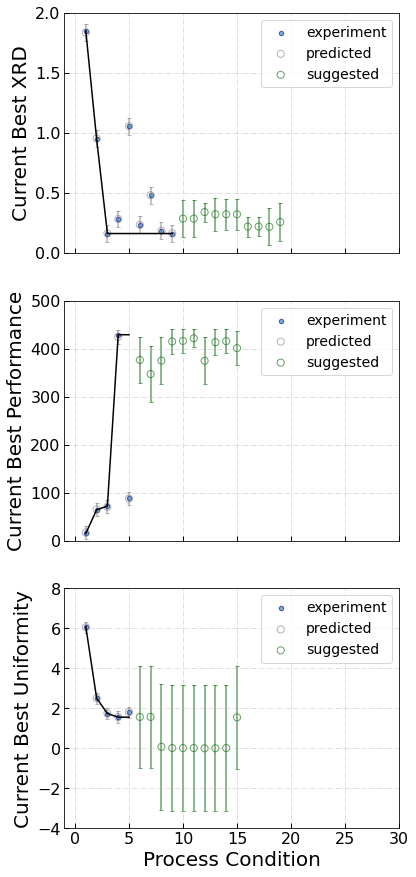

In [32]:
film_xrd = y2
fig, axes = plt.subplots(3, 1, figsize=(6, 15), sharey = False, sharex = True)
fs = 20
exp_cond = (np.arange(len(y2))+1).reshape(-1,1)
exp_xrd = film_xrd.reshape(-1,1)

f_obj =  objective_model2.model.predict
y_pred, y_uncer = f_obj(X2)
y_pred = y_pred[:,-1]+0.5
y_uncer = np.sqrt(y_uncer[:,-1])


axes[0].scatter(exp_cond, exp_xrd, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 0.6, label = 'experiment')

axes[0].plot(exp_cond, np.minimum.accumulate(exp_xrd), 
         marker = 'o', ms = 0, c = 'black')

axes[0].scatter(exp_cond, y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')
axes[0].errorbar(exp_cond, y_pred, yerr = y_uncer,  
                 ms = 1, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)


y_pred_new, y_uncer_new = f_obj(x_normalizer(df_Xnew.values))
y_pred_new = y_pred_new[:,-1]+0.5
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

axes[0].scatter(np.arange(len(df_Xnew))+1+len(X2), y_pred_new,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
axes[0].errorbar(np.arange(len(df_Xnew))+1+len(X2), y_pred_new, yerr = y_uncer_new,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'darkgreen', zorder = 0)


axes[0].set_ylabel('Current Best XRD', fontsize = 20)

axes[0].set_ylim(0, 2)
axes[0].set_xlim(-1, 30)
axes[0].set_xticks(np.arange(0,35,5))
axes[0].legend(fontsize = fs*0.7)

film_life = y4
fs = 20
exp_cond = (np.arange(len(y4))+1).reshape(-1,1)
exp_life = film_life.reshape(-1,1)

f_obj =  objective_model4.model.predict
y_pred, y_uncer = f_obj(X4)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

axes[1].scatter(exp_cond, exp_life, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 0.6, label = 'experiment')

axes[1].plot(exp_cond, np.maximum.accumulate(exp_life), 
         marker = 'o', ms = 0, c = 'black')

axes[1].scatter(exp_cond, y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')
axes[1].errorbar(exp_cond, y_pred, yerr = y_uncer,  
                 ms = 1, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)


y_pred_new, y_uncer_new = f_obj(x_normalizer(df_Xnew.values))
y_pred_new = -y_pred_new[:,-1]
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

axes[1].scatter(np.arange(len(df_Xnew))+1+len(X4), y_pred_new,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
axes[1].errorbar(np.arange(len(df_Xnew))+1+len(X4), y_pred_new, yerr = y_uncer_new,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'darkgreen', zorder = 0)
axes[1].set_ylim(0, 500)
axes[1].set_ylabel('Current Best Performance', fontsize = 20)
axes[1].legend(fontsize = fs*0.7)

film_uniform = y3
fs = 20
exp_cond = (np.arange(len(y3))+1).reshape(-1,1)
exp_uniform = film_uniform.reshape(-1,1)

f_obj =  objective_model3.model.predict
y_pred, y_uncer = f_obj(X3)
y_pred = y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])


axes[2].scatter(exp_cond, exp_uniform, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 0.6, label = 'experiment')

axes[2].plot(exp_cond, np.minimum.accumulate(exp_uniform), 
         marker = 'o', ms = 0, c = 'black')

axes[2].scatter(exp_cond, y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')
axes[2].errorbar(exp_cond, y_pred, yerr = y_uncer,  
                 ms = 1, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)


y_pred_new, y_uncer_new = f_obj(x_normalizer(df_Xnew.values))
y_pred_new = y_pred_new[:,-1]
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

axes[2].scatter(np.arange(len(df_Xnew))+1+len(X3), y_pred_new,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
axes[2].errorbar(np.arange(len(df_Xnew))+1+len(X3), y_pred_new, yerr = y_uncer_new,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'darkgreen', zorder = 0)
axes[2].set_ylim(-4, 8)
axes[2].legend(fontsize = fs*0.7)
axes[2].set_ylabel('Current Best Uniformity', fontsize = 20)
axes[2].set_xlabel('Process Condition', fontsize = 20)

for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

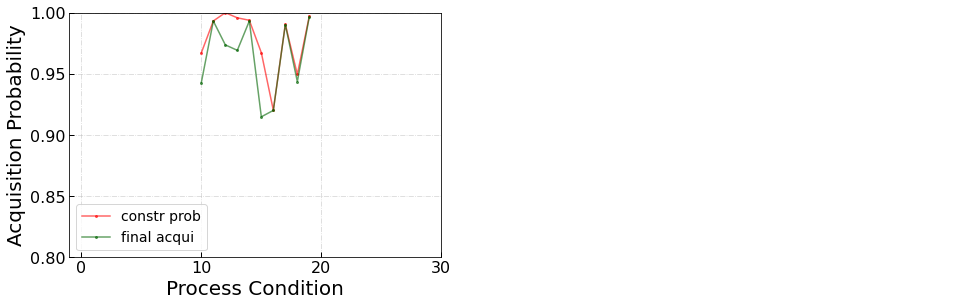

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4.5), sharey = False)
fs = 20

# axes[0].plot(np.arange(len(df_Xnew))+1+len(X2), acq_new1, marker = 'o',
#                 ms = 2, alpha = 0.6, color = 'orange', label = 'raw acqui1')
# axes[0].plot(np.arange(len(df_Xnew))+1+len(X2), acq_new1, marker = 'o',
#                 ms = 2, alpha = 0.6, color = 'navy', label = 'raw acqui2')
axes[0].plot(np.arange(len(df_Xnew))+1+len(X2), cons_pr, marker = 'o',
                ms = 2, alpha = 0.6, color = 'red', label = 'constr prob')
axes[0].plot(np.arange(len(df_Xnew))+1+len(X2), final_acq, marker = 'o',
                ms = 2, alpha = 0.6, color = 'darkgreen', label = 'final acqui')

axes[0].set_ylim(0.8, 1)
axes[0].set_xlim(-1, 30)
axes[0].set_xticks(np.arange(0,40,10))
axes[0].set_ylabel('Acquisition Probability', fontsize = fs)
axes[0].set_xlabel('Process Condition', fontsize = fs)
axes[0].legend(fontsize = fs*0.7)

axes[1].axis("off")
for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

###DMF、V correlates to film quality, maximize film quality, see max contour plot (based on lengthscale of GP model)

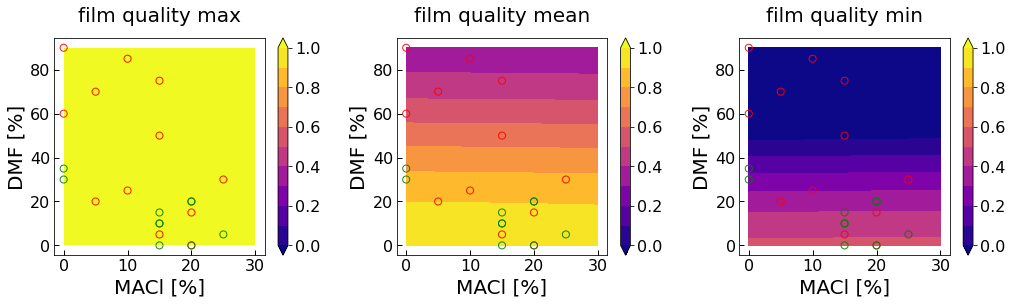

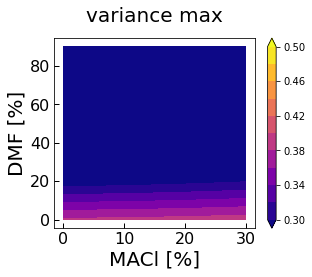

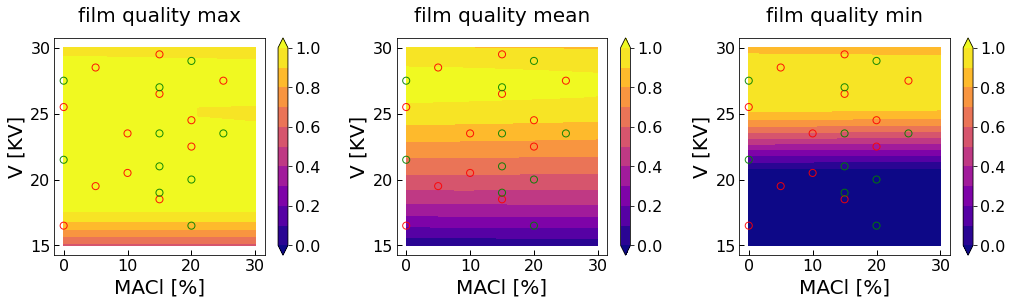

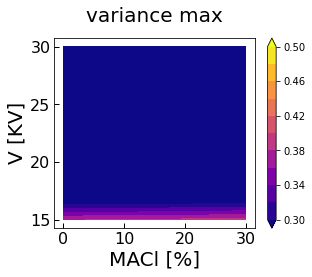

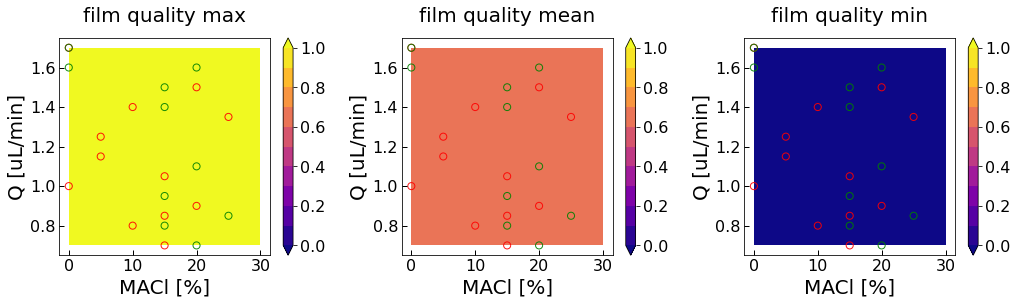

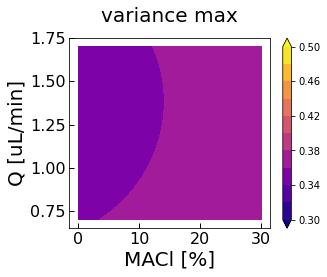

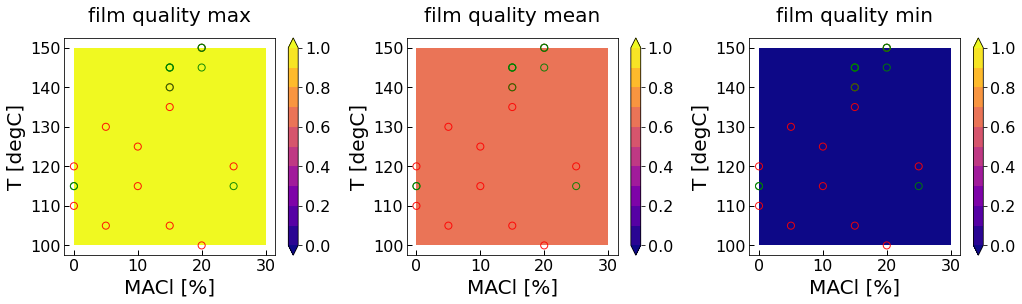

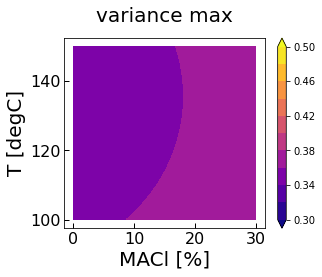

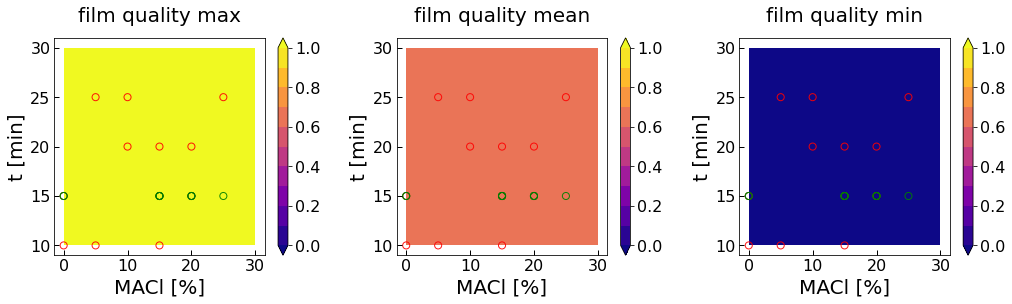

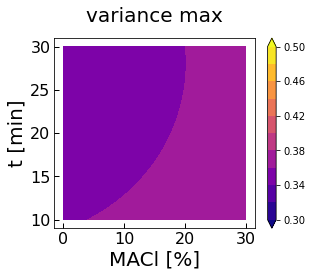

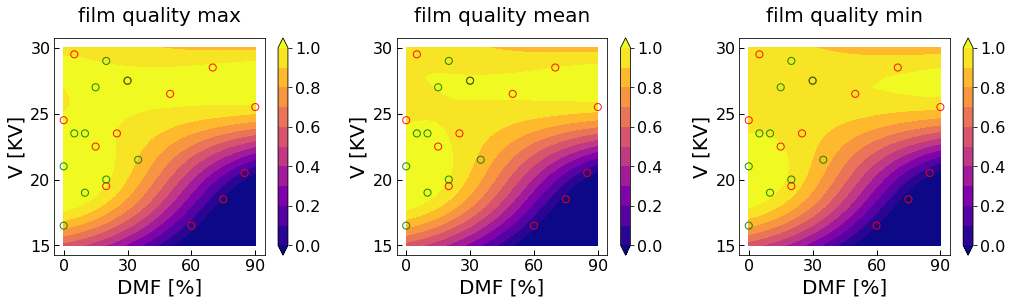

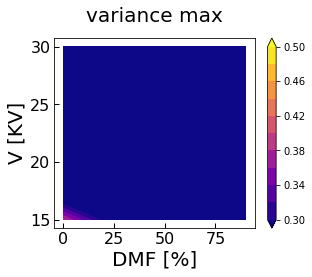

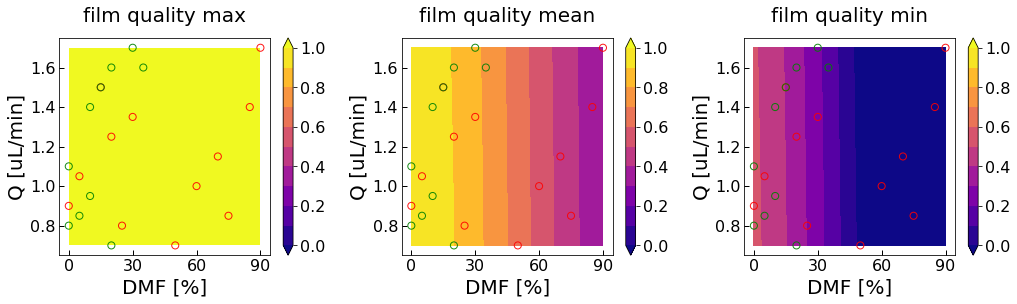

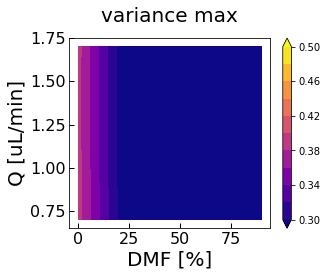

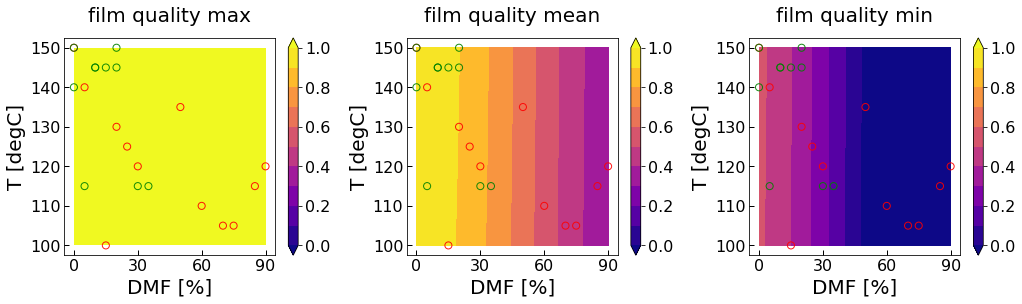

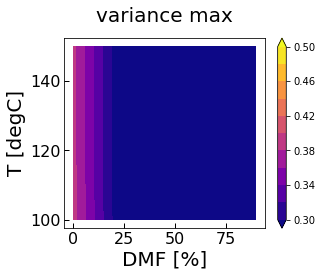

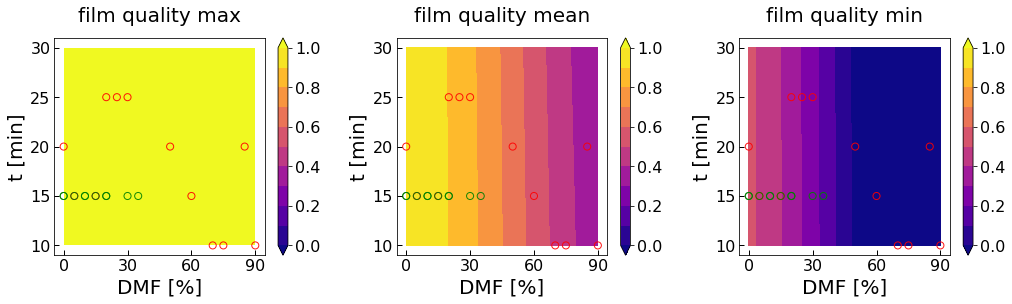

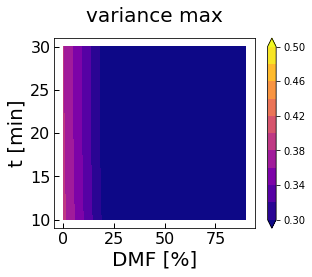

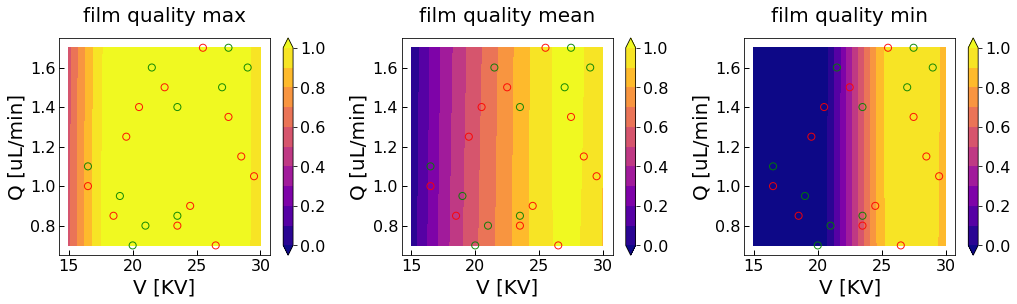

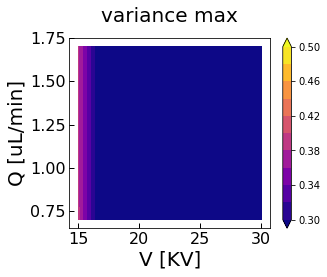

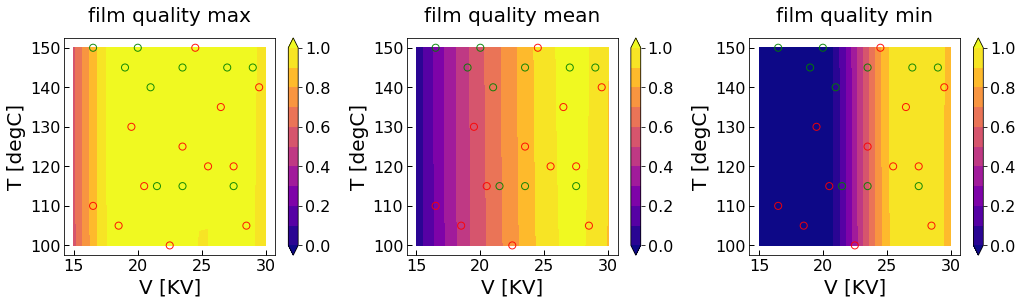

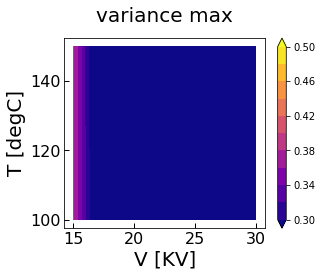

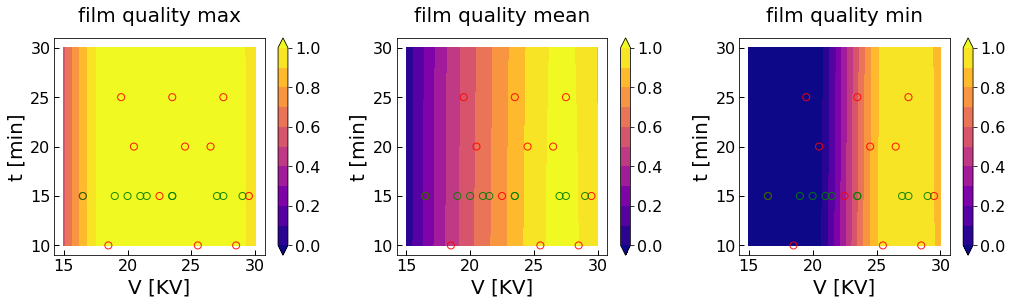

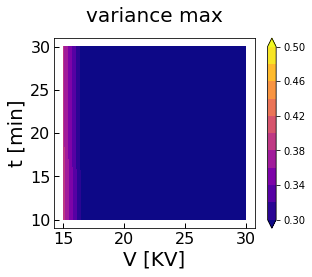

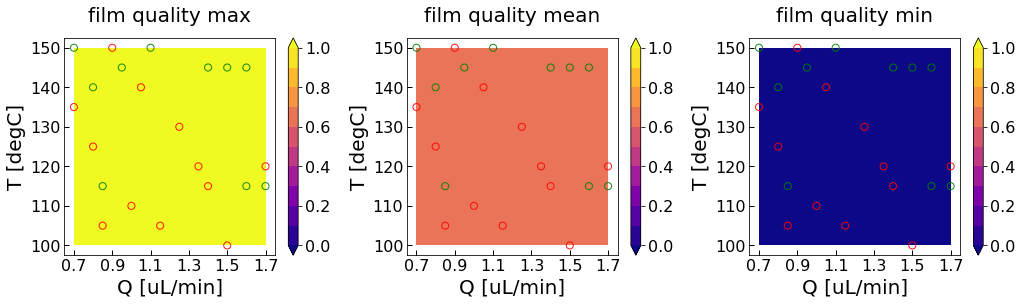

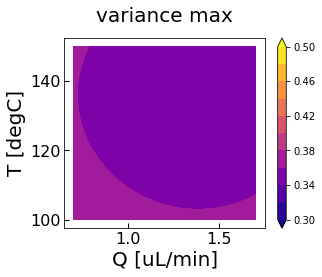

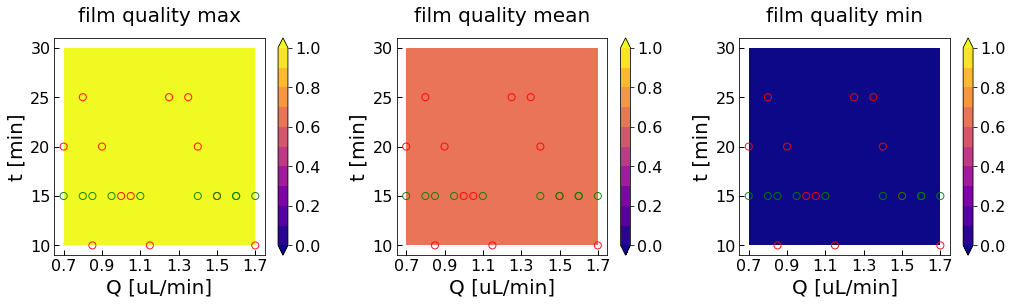

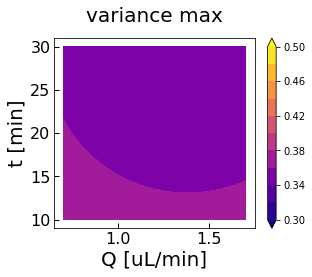

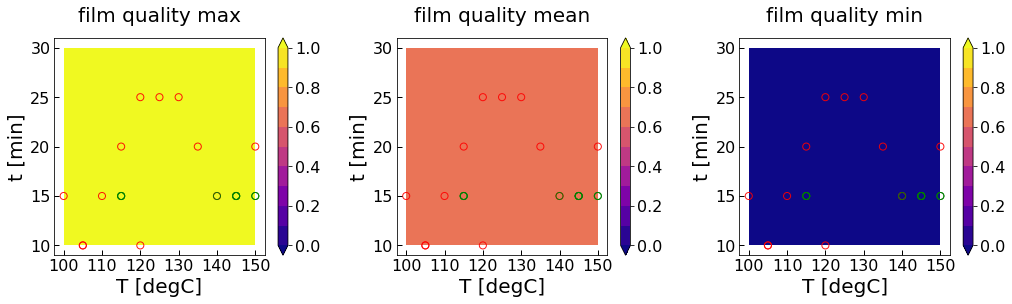

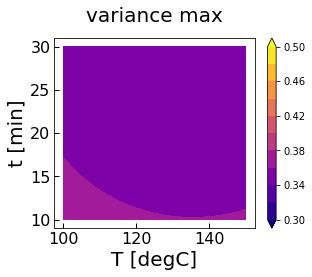

In [35]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_sampled = x_sampled
input_dim = 6
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj1(x_temp)
                y2 = -y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y2), np.mean(y2), np.min(y2)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
        
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
            
        y_max2 = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_mean2 = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_min2 = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 20
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0]
        for ax, y in zip(axes,
                           [y_max2, y_mean2, y_min2]):
            c_plt1 = ax.contourf(x1, x2, y,levels = np.arange(11)*0.1+colorbar_offset, cmap='plasma',extend='both')
#             std = ax.contour(x1, x2, y,[0.5],cmap='coolwarm')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X1)[:, ind1], 
                       x_denormalizer(X1)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter((X_new)[:, ind1], 
                       (X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_labels[ind2]),fontsize =  fs)
            
            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
            if ind1==1:#DMF%
                ax.set_xticks([0, 30, 60, 90])
            if ind1==2:#V
                ax.set_xticks([15, 20, 25, 30])
            if ind1==3:#Q
                ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
            if ind1==4:#T
                ax.set_xticks([100, 110, 120, 130, 140, 150])
            if ind1==5:#t
                ax.set_yticks([10, 15, 20, 25, 30])
                
        axes[0].set_title('film quality max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('film quality mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('film quality min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()
        
        fig,axes = plt.subplots(1, 1, figsize=(4.5, 3.5), sharey =False, sharex = False) 
        colorbar_offset = [0.3]
        c_plt3 = axes.contourf(x1, x2, y_uncer_max, levels = np.arange(11)*0.02+colorbar_offset, cmap='plasma',extend='both')
        cbar = fig.colorbar(c_plt3, ax = axes)
        axes.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
        axes.set_ylabel(str(x_labels[ind2]),fontsize =  fs)

        x1_delta = (np.max(x1)-np.min(x1))*0.05
        x2_delta = (np.max(x2)-np.min(x2))*0.05
        axes.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
        axes.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
        axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
        if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
        if ind1==1:#DMF%
            ax.set_xticks([0, 30, 60, 90])
        if ind1==2:#V
            ax.set_xticks([15, 20, 25, 30])
        if ind1==3:#Q
            ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
        if ind1==4:#T
            ax.set_xticks([100, 110, 120, 130, 140, 150])
        if ind1==5:#t
            ax.set_yticks([10, 15, 20, 25, 30])
            
#         axes.scatter(x_denormalizer(X1)[:, 0], 
#                        x_denormalizer(X1)[:, 1], 
#                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
        axes.set_title('variance max', pad = title_pad,fontsize =  fs)

###MACl、T correlates to XRD, mniimize XRD, see min contour plot 

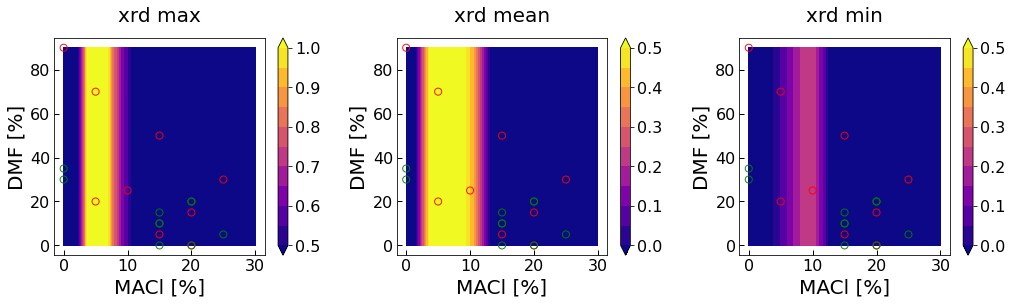

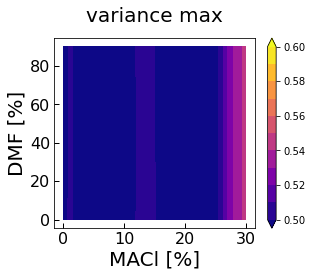

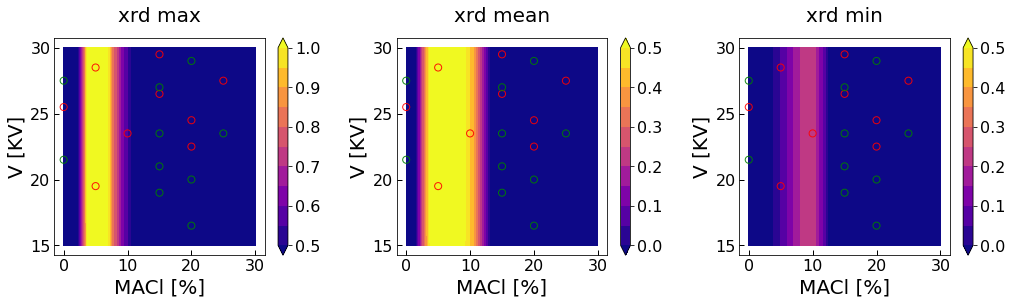

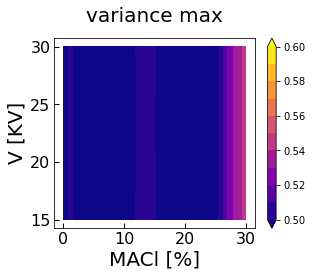

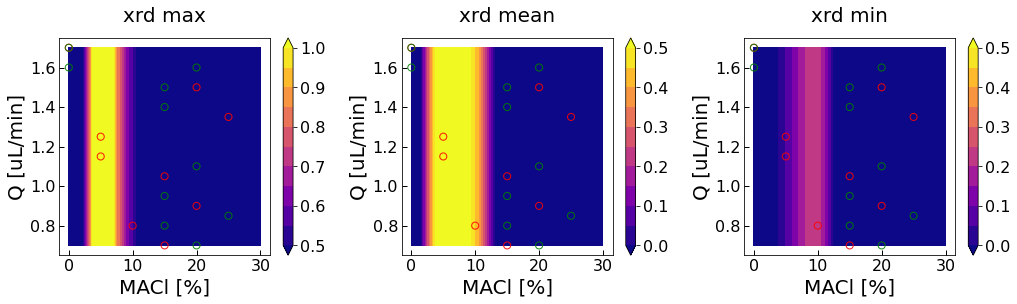

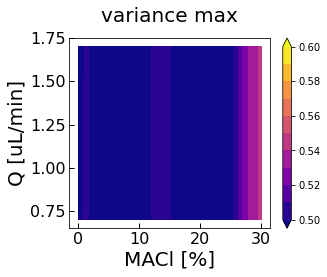

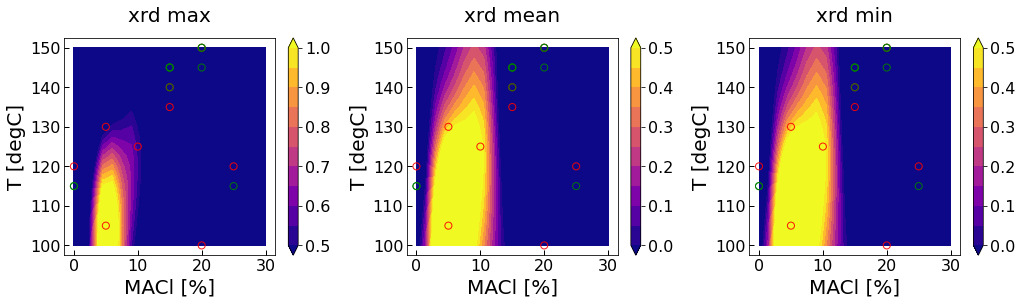

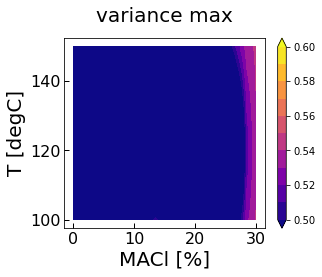

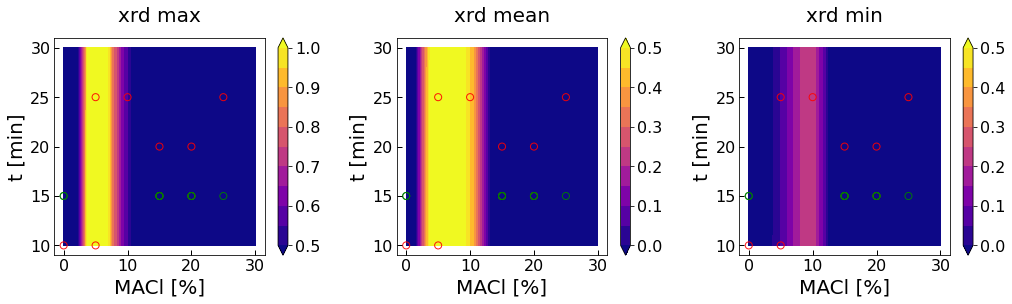

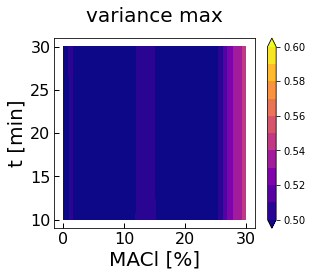

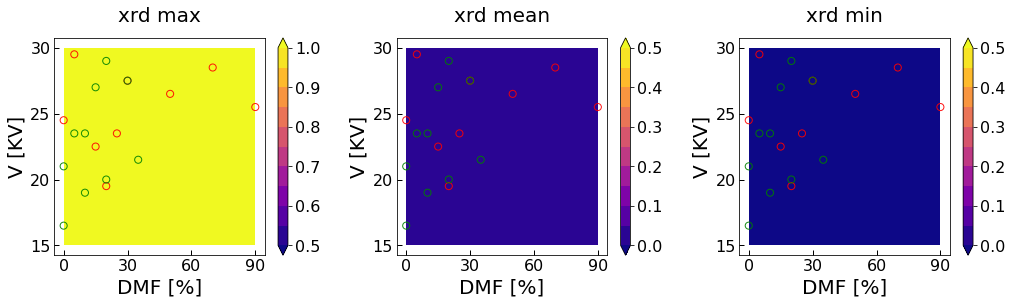

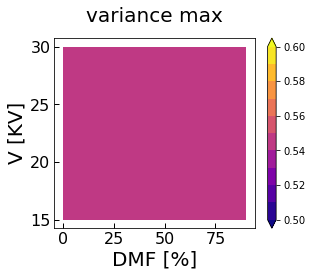

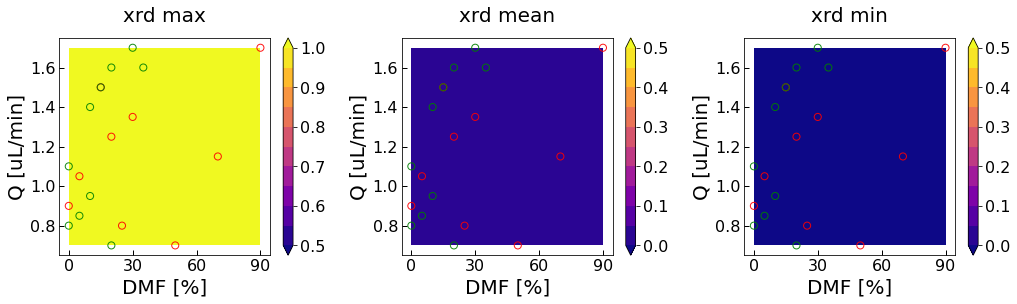

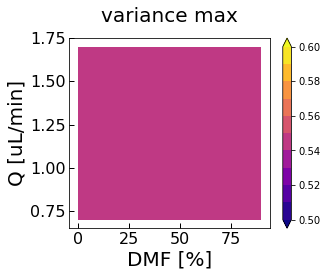

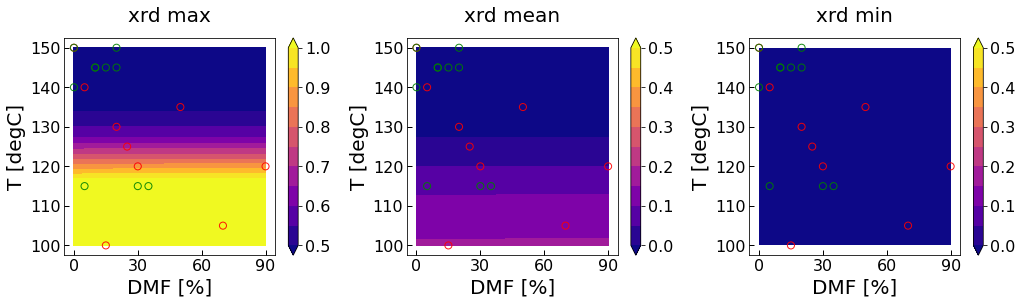

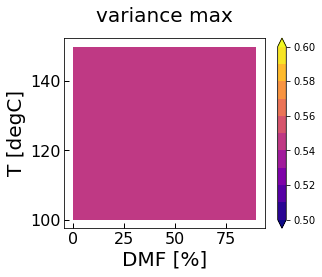

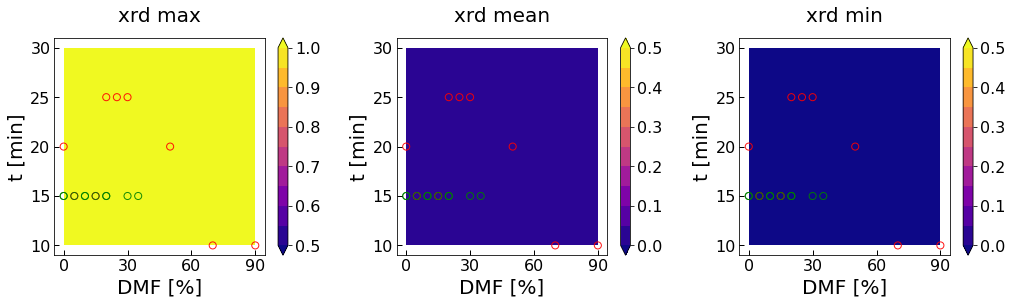

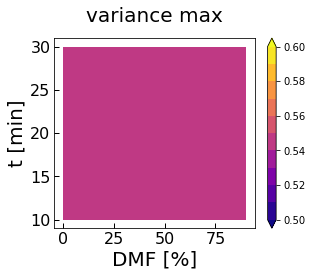

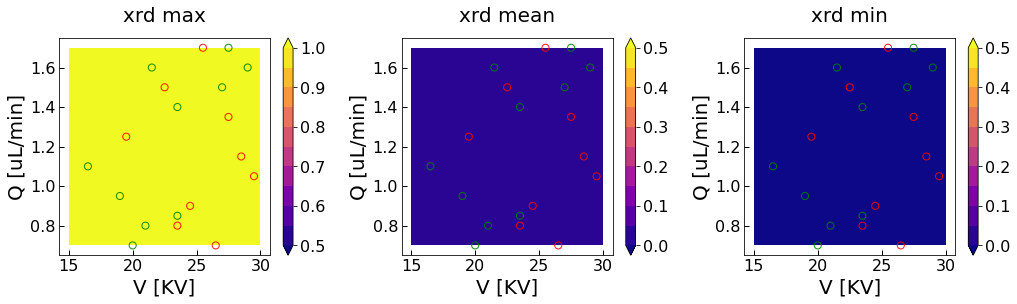

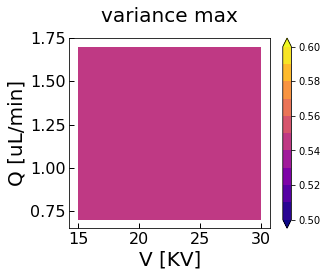

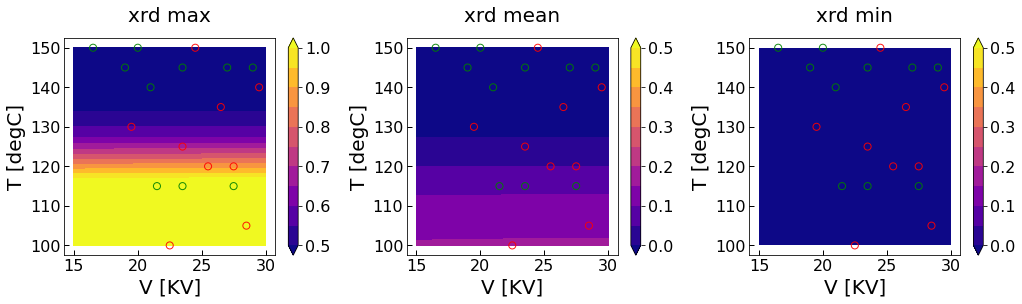

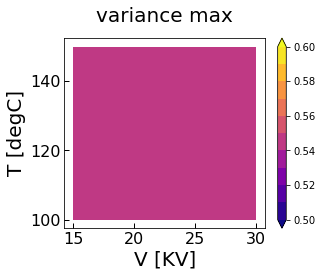

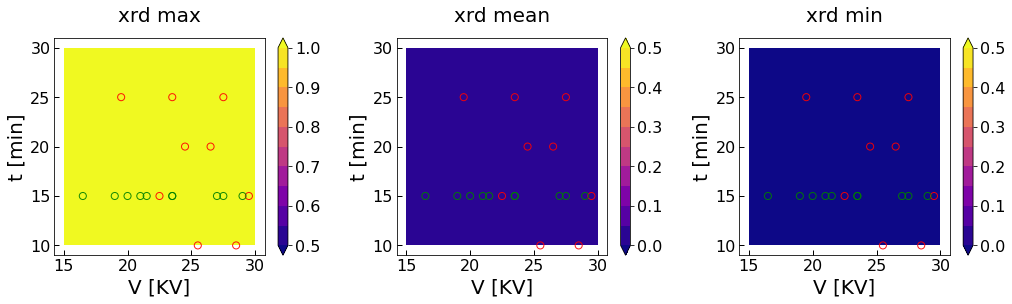

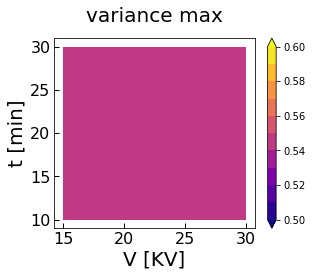

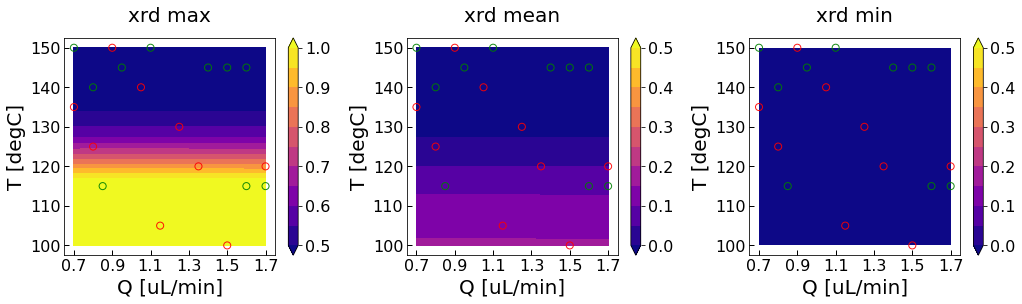

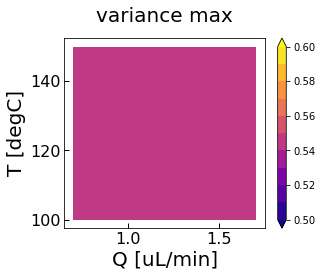

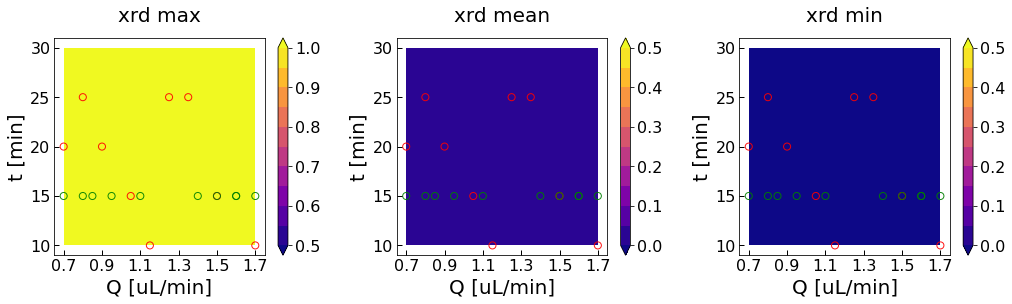

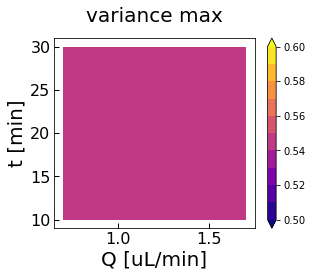

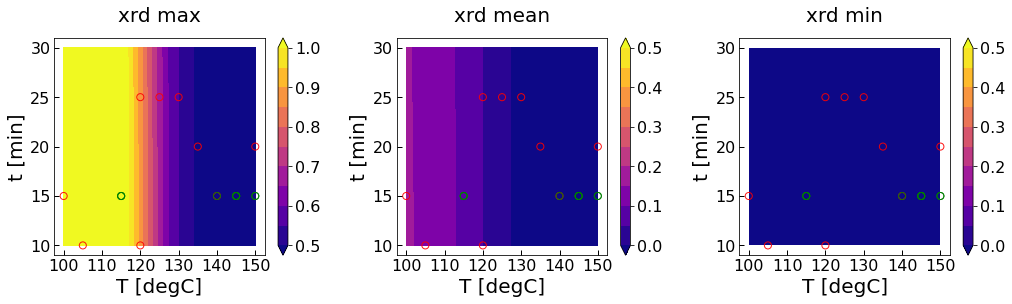

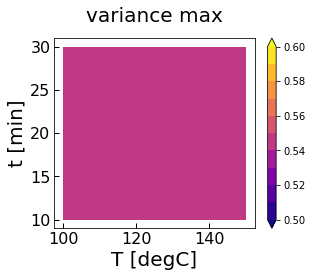

In [34]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_sampled = x_sampled
input_dim = 6
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj2(x_temp)
                y2 = y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y2), np.mean(y2), np.min(y2)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
        
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
            
        y_max2 = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_mean2 = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_min2 = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 20
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         for ax, y in zip(axes,
#                    [y_max2, y_mean2, y_min2]):
#             c_plt1 = ax.contourf(x1, x2, y,cmap='plasma',extend='both')
        colorbar_offset = [0.5, 0, 0]
        for ax, c_offset, y in zip(axes,colorbar_offset,
                           [y_max2, y_mean2, y_min2]):
            c_plt1 = ax.contourf(x1, x2, y,levels = np.arange(11)*0.05+c_offset,cmap='plasma',extend='both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X2)[:, ind1], 
                       x_denormalizer(X2)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter((X_new)[:, ind1], 
                       (X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_labels[ind2]),fontsize =  fs)
            
            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
            if ind1==1:#DMF%
                ax.set_xticks([0, 30, 60, 90])
            if ind1==2:#V
                ax.set_xticks([15, 20, 25, 30])
            if ind1==3:#Q
                ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
            if ind1==4:#T
                ax.set_xticks([100, 110, 120, 130, 140, 150])
            if ind1==5:#t
                ax.set_yticks([10, 15, 20, 25, 30])
                
        axes[0].set_title('xrd max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('xrd mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('xrd min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()
        
        fig,axes = plt.subplots(1, 1, figsize=(4.5, 3.5), sharey =False, sharex = False) 
#         c_plt3 = axes.contourf(x1, x2, y_uncer_max, cmap='plasma',extend='both')
        colorbar_offset = [0.5]
        c_plt3 = axes.contourf(x1, x2, y_uncer_max, levels = np.arange(11)*0.01+colorbar_offset, cmap='plasma',extend='both')
        cbar = fig.colorbar(c_plt3, ax = axes)
        axes.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
        axes.set_ylabel(str(x_labels[ind2]),fontsize =  fs)

        x1_delta = (np.max(x1)-np.min(x1))*0.05
        x2_delta = (np.max(x2)-np.min(x2))*0.05
        axes.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
        axes.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
        axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
        if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
        if ind1==1:#DMF%
            ax.set_xticks([0, 30, 60, 90])
        if ind1==2:#V
            ax.set_xticks([15, 20, 25, 30])
        if ind1==3:#Q
            ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
        if ind1==4:#T
            ax.set_xticks([100, 110, 120, 130, 140, 150])
        if ind1==5:#t
            ax.set_yticks([10, 15, 20, 25, 30])
            
#         axes.scatter(x_denormalizer(X1)[:, 0], 
#                        x_denormalizer(X1)[:, 1], 
#                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
        axes.set_title('variance max', pad = title_pad,fontsize =  fs)

###DMF、t correlates to TRPL, maximize TRPL, see max contour plot 

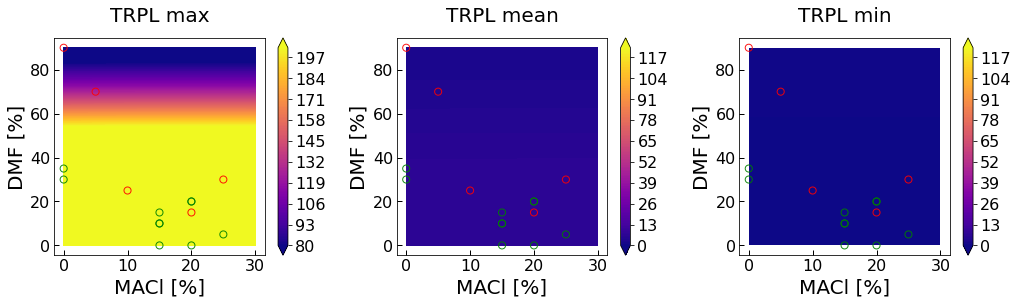

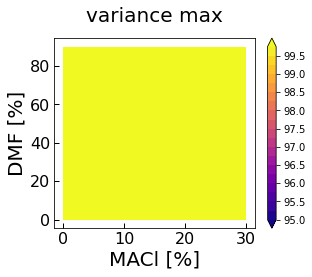

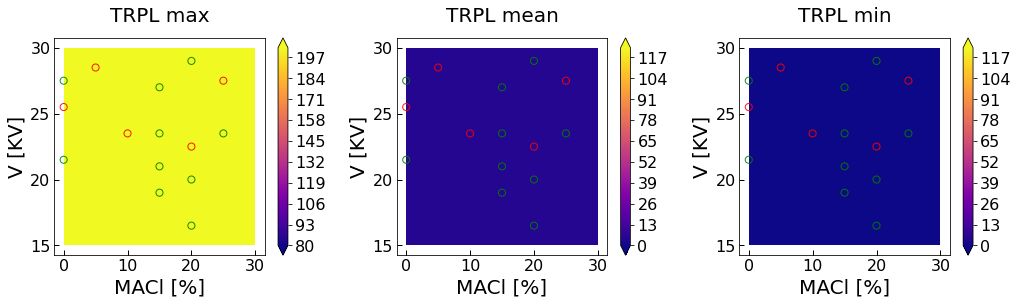

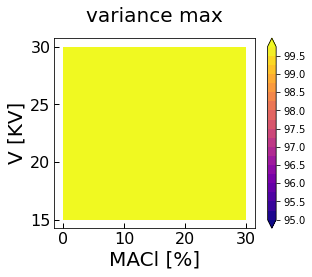

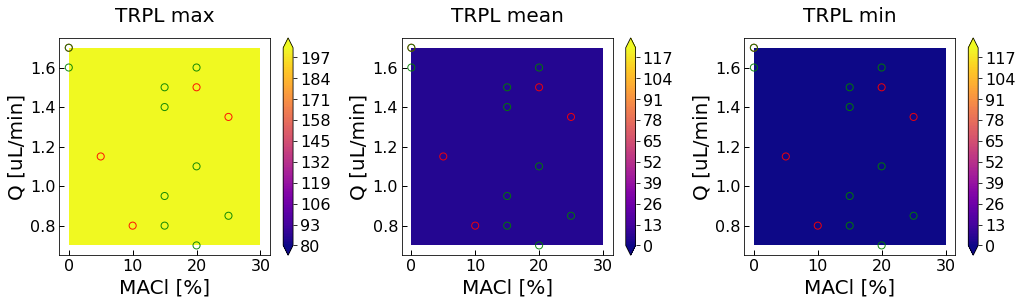

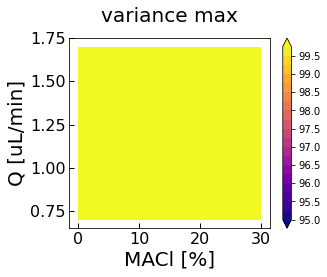

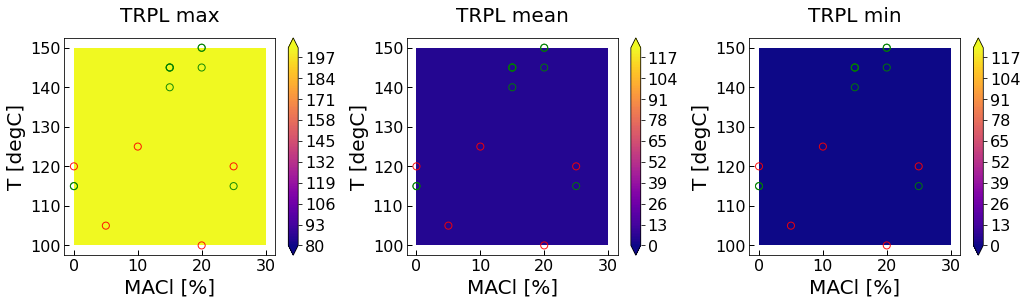

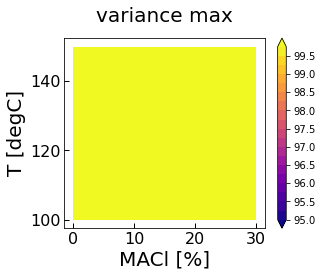

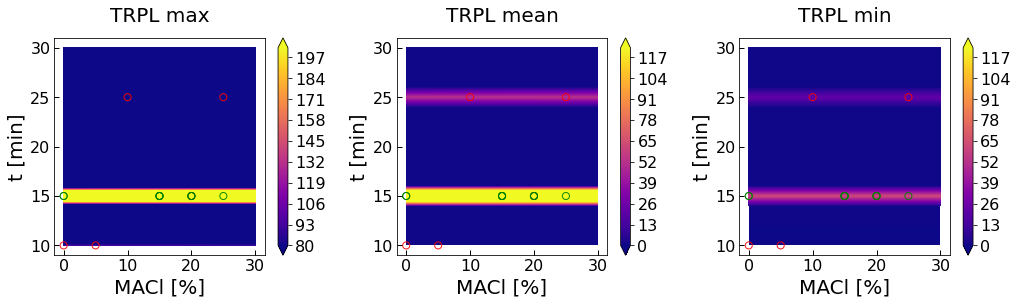

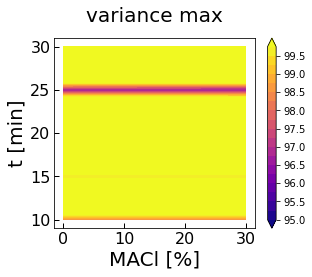

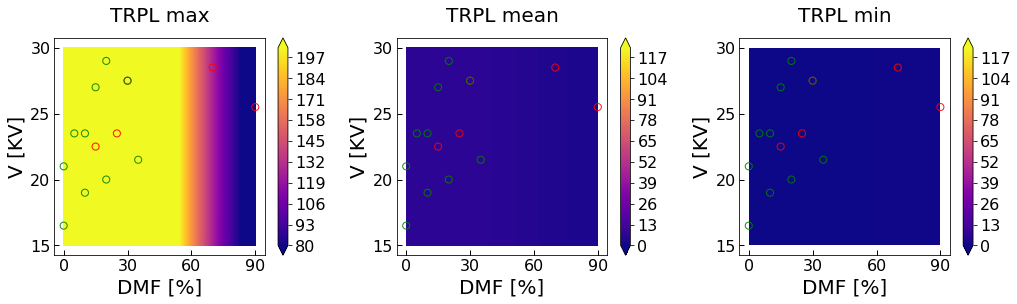

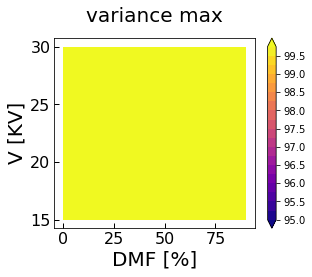

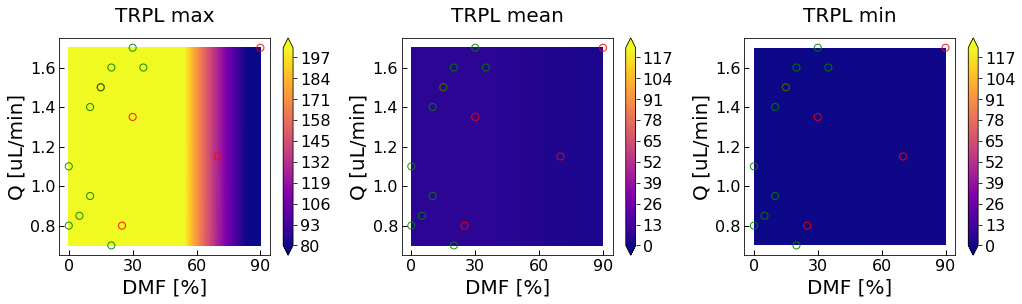

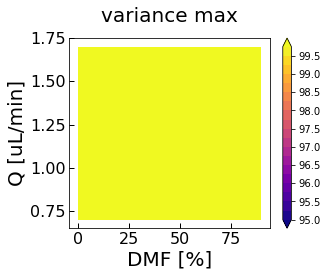

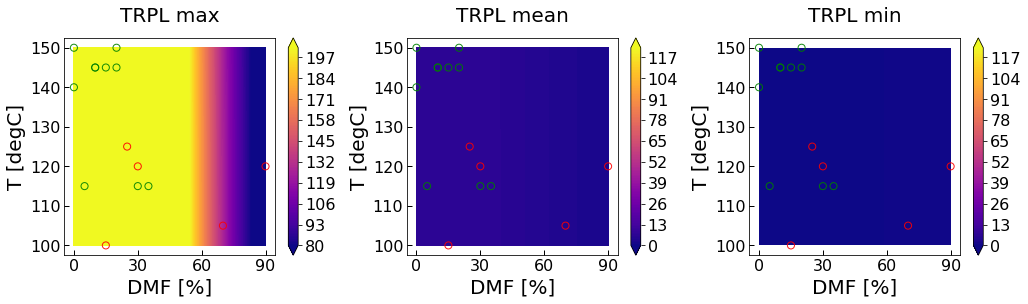

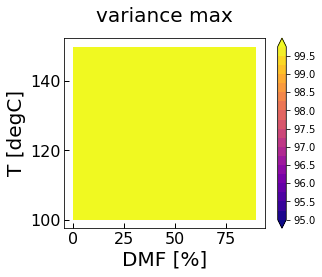

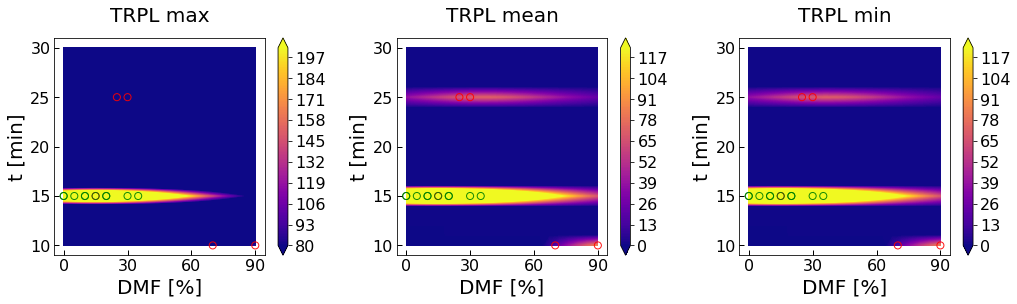

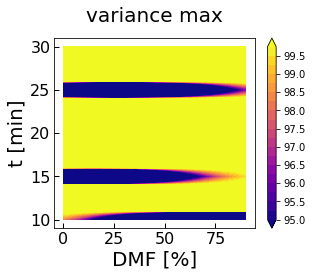

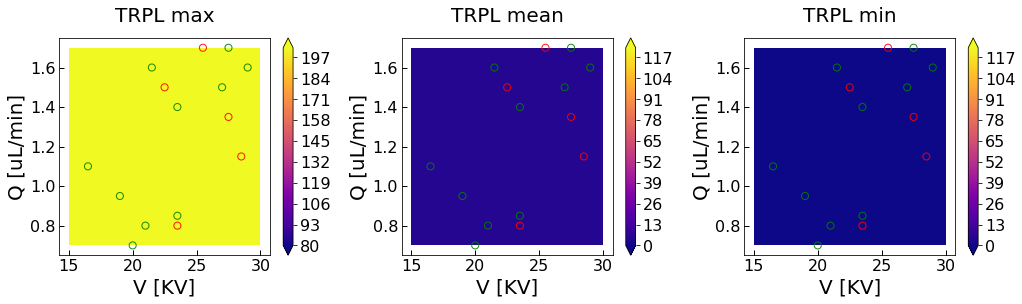

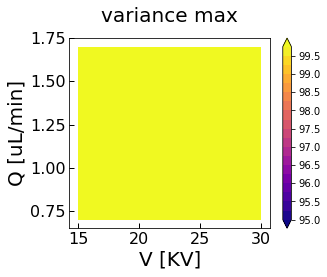

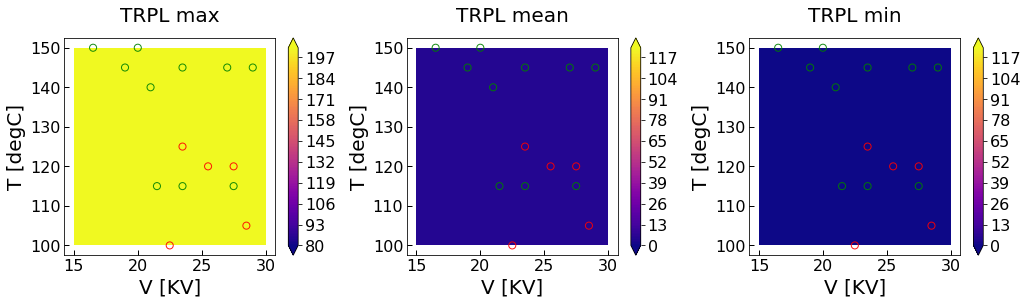

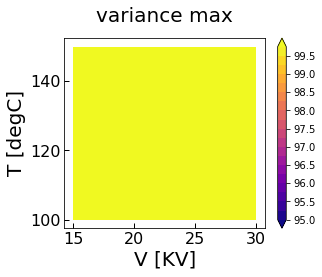

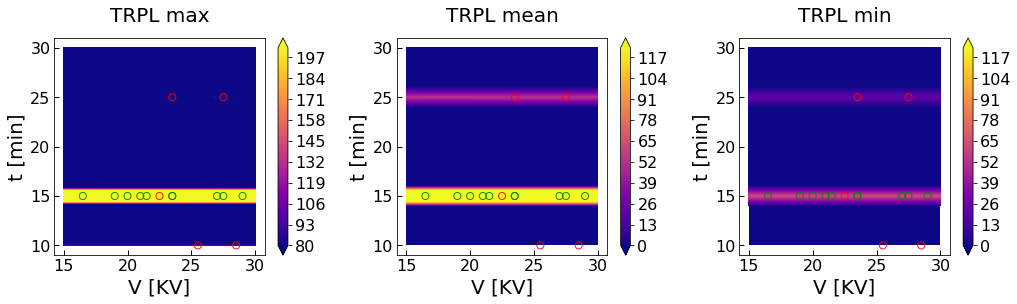

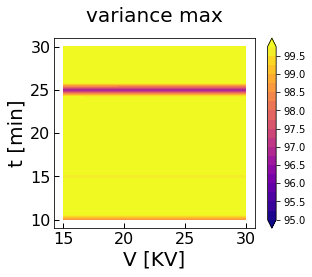

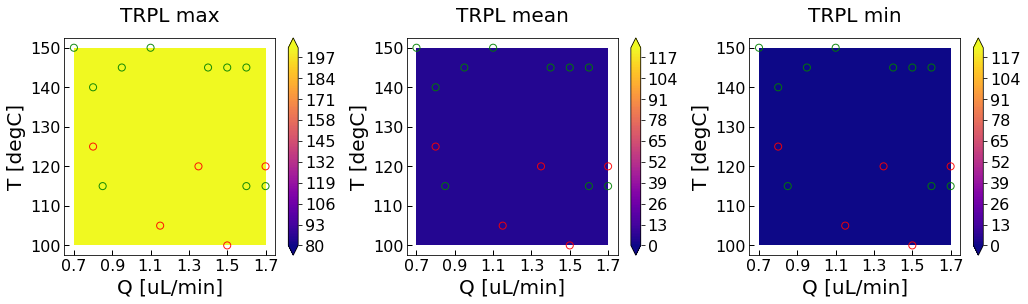

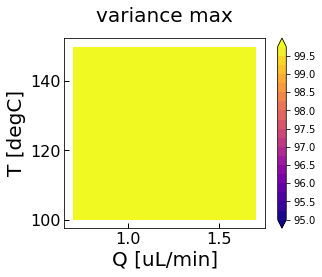

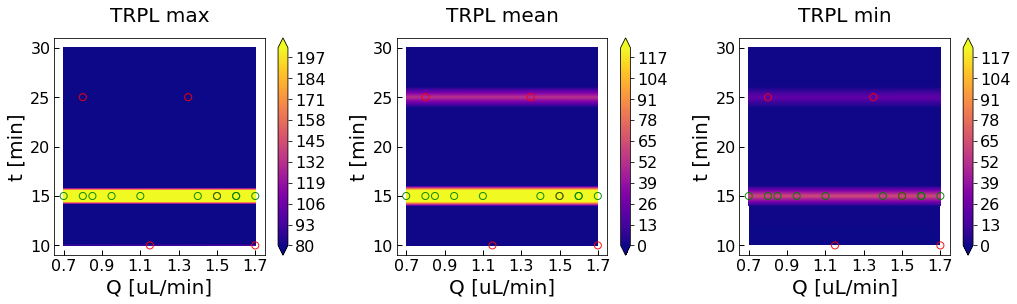

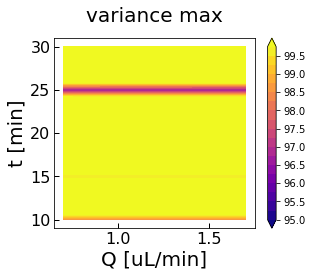

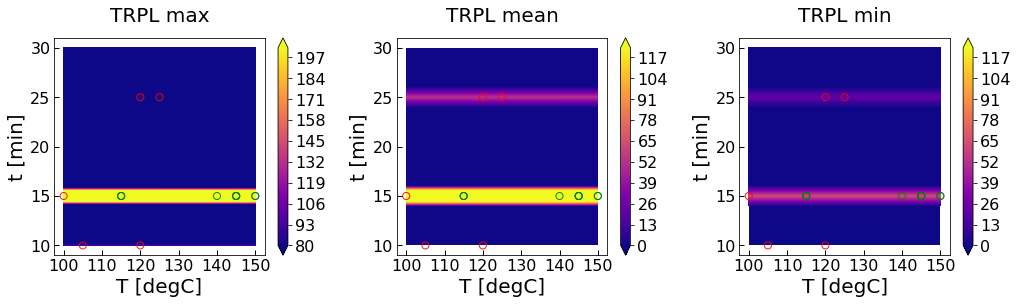

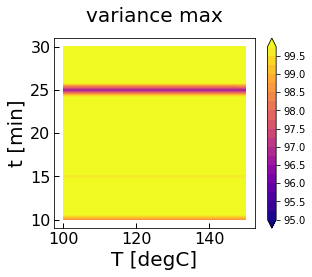

In [43]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_sampled = x_sampled
input_dim = 6
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj4(x_temp)
                y2 = -y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y2), np.mean(y2), np.min(y2)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
        
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
            
        y_max2 = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_mean2 = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_min2 = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 20
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         for ax, y in zip(axes,
#                            [y_max2, y_mean2, y_min2]):
#             c_plt1 = ax.contourf(x1, x2, y,cmap='plasma',extend='both')
        colorbar_offset = [80, 0, 0]
        for ax, c_offset, y in zip(axes,colorbar_offset,
                           [y_max2, y_mean2, y_min2]):
            c_plt1 = ax.contourf(x1, x2, y,levels = np.arange(124)+c_offset,cmap='plasma',extend='both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X3)[:, ind1], 
                       x_denormalizer(X3)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter((X_new)[:, ind1], 
                       (X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_labels[ind2]),fontsize =  fs)
            
            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
            if ind1==1:#DMF%
                ax.set_xticks([0, 30, 60, 90])
            if ind1==2:#V
                ax.set_xticks([15, 20, 25, 30])
            if ind1==3:#Q
                ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
            if ind1==4:#T
                ax.set_xticks([100, 110, 120, 130, 140, 150])
            if ind1==5:#t
                ax.set_yticks([10, 15, 20, 25, 30])
                
        axes[0].set_title('TRPL max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('TRPL mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('TRPL min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()
        
        fig,axes = plt.subplots(1, 1, figsize=(4.5, 3.5), sharey =False, sharex = False) 
#         c_plt3 = axes.contourf(x1, x2, y_uncer_max, cmap='plasma',extend='both')
        colorbar_offset = [95]
        c_plt3 = axes.contourf(x1, x2, y_uncer_max, levels = np.arange(20)*0.25+colorbar_offset, cmap='plasma',extend='both')
        cbar = fig.colorbar(c_plt3, ax = axes)
        axes.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
        axes.set_ylabel(str(x_labels[ind2]),fontsize =  fs)

        x1_delta = (np.max(x1)-np.min(x1))*0.05
        x2_delta = (np.max(x2)-np.min(x2))*0.05
        axes.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
        axes.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
        axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
        if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
        if ind1==1:#DMF%
            ax.set_xticks([0, 30, 60, 90])
        if ind1==2:#V
            ax.set_xticks([15, 20, 25, 30])
        if ind1==3:#Q
            ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
        if ind1==4:#T
            ax.set_xticks([100, 110, 120, 130, 140, 150])
        if ind1==5:#t
            ax.set_yticks([10, 15, 20, 25, 30])
            
#         axes.scatter(x_denormalizer(X1)[:, 0], 
#                        x_denormalizer(X1)[:, 1], 
#                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
        axes.set_title('variance max', pad = title_pad,fontsize =  fs)

###T correlates to PL, minimize PL, see min contour plot 

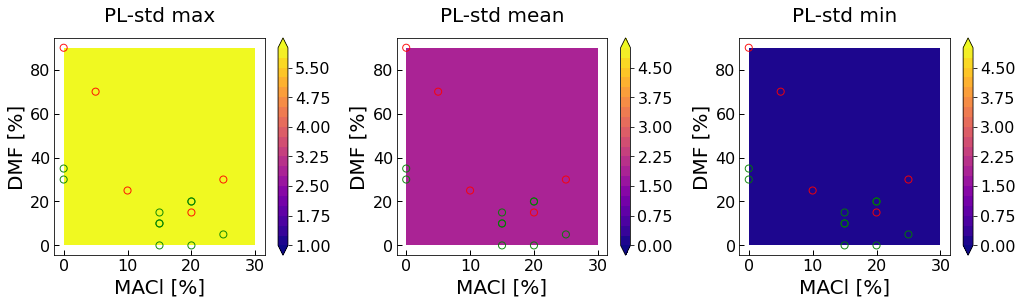

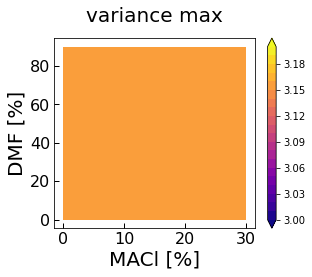

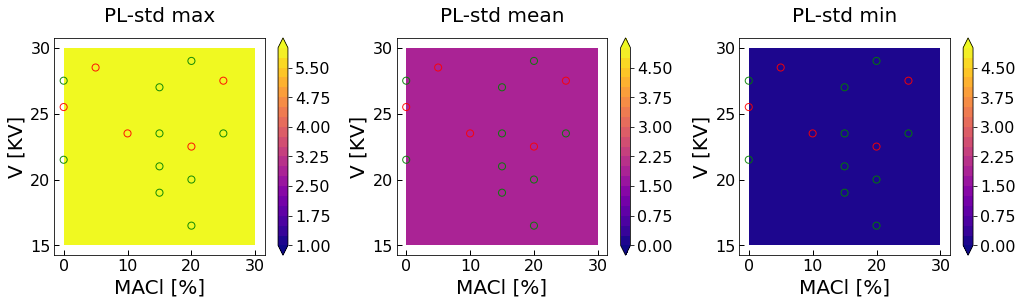

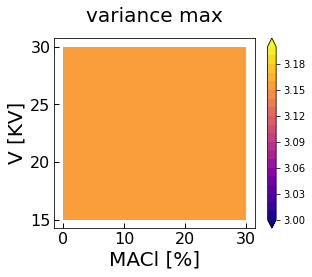

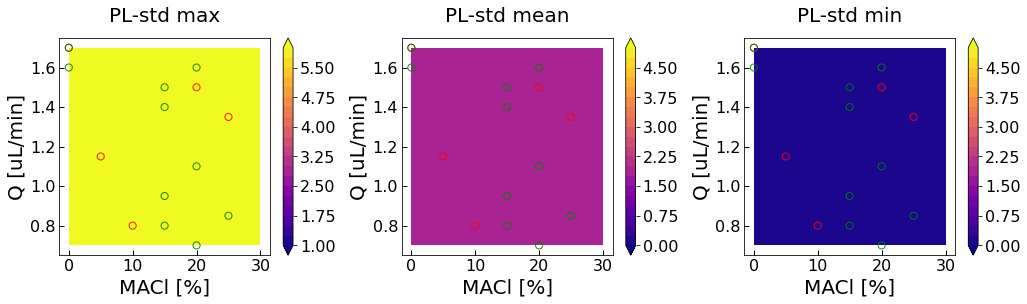

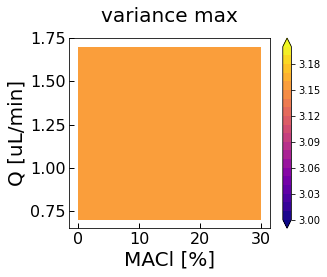

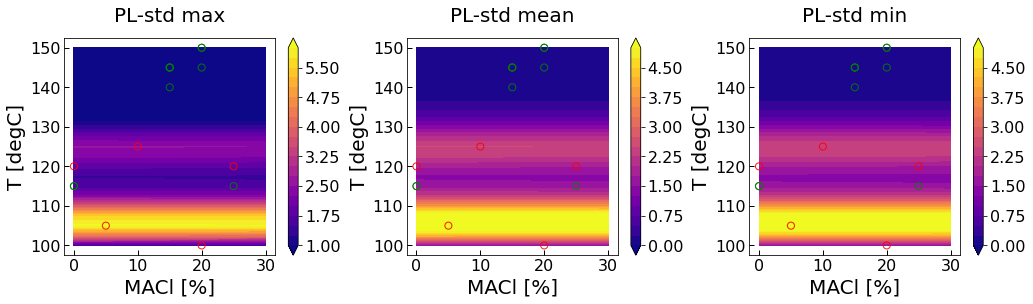

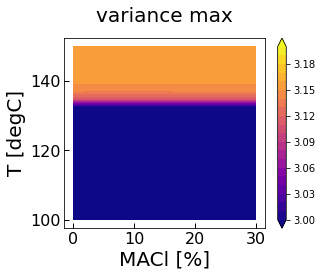

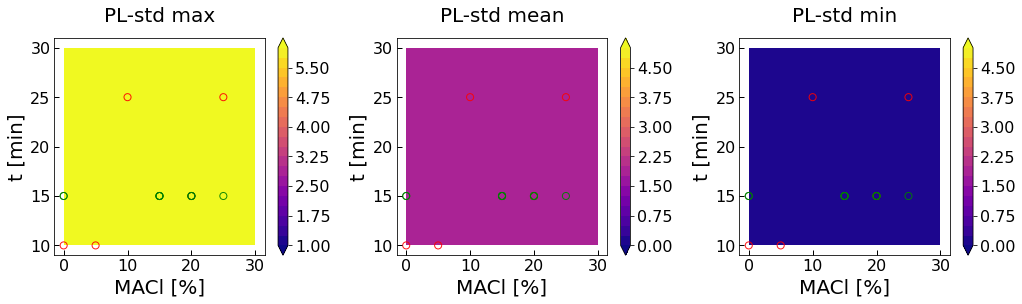

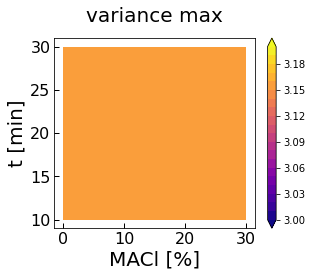

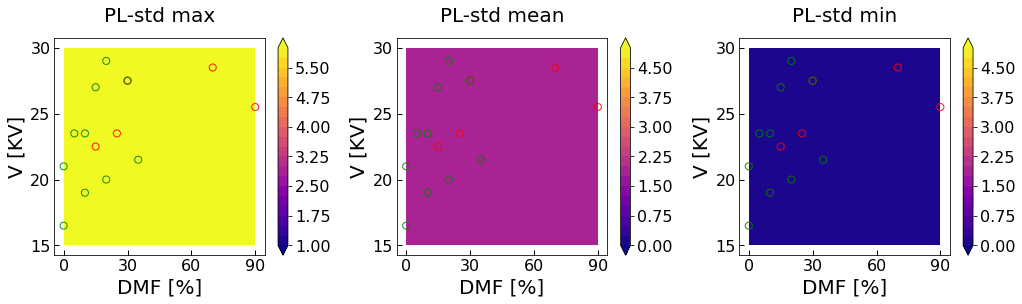

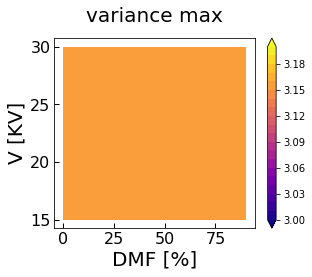

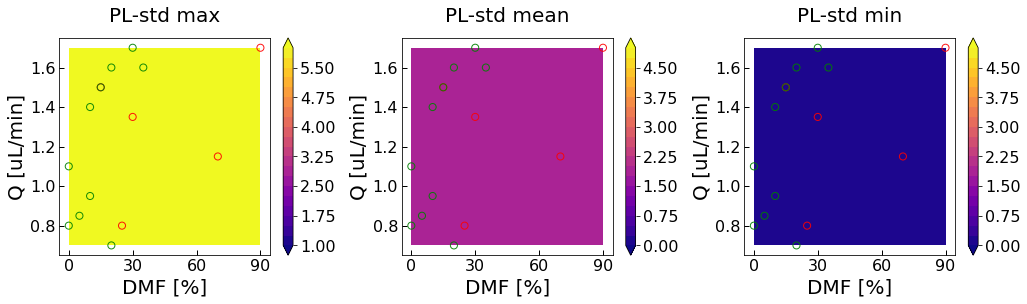

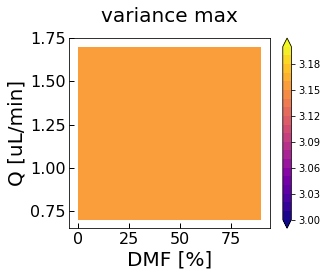

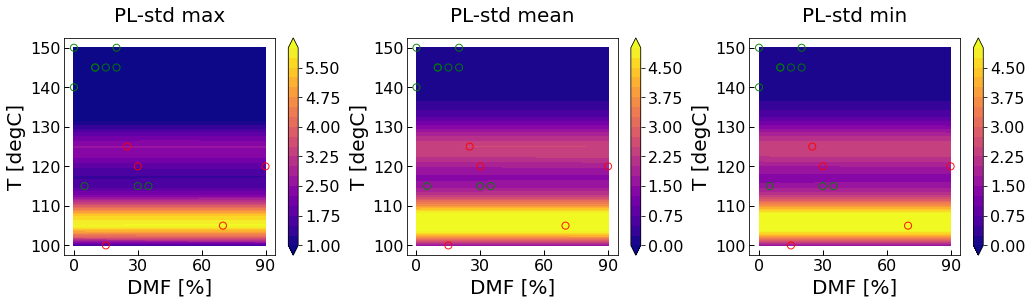

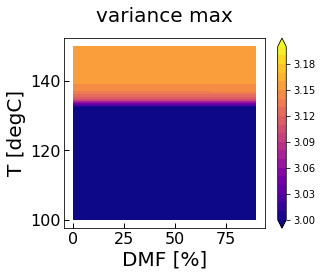

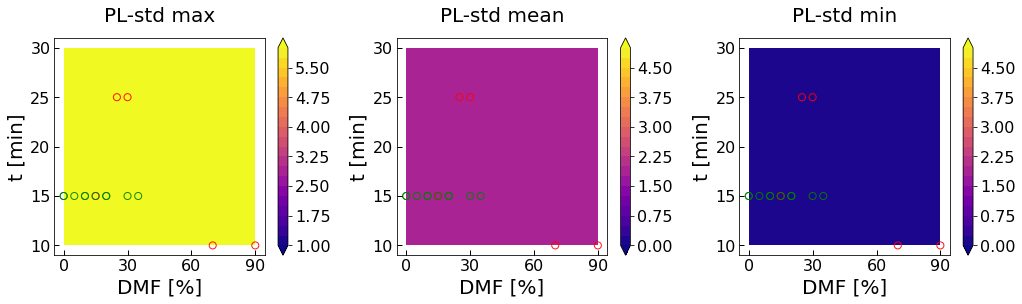

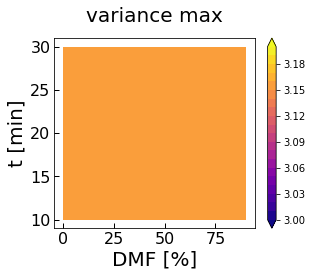

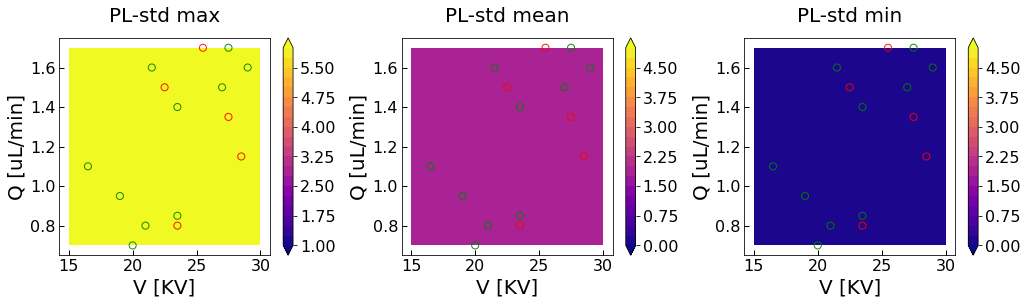

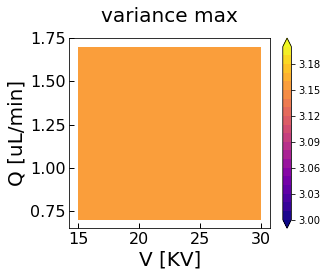

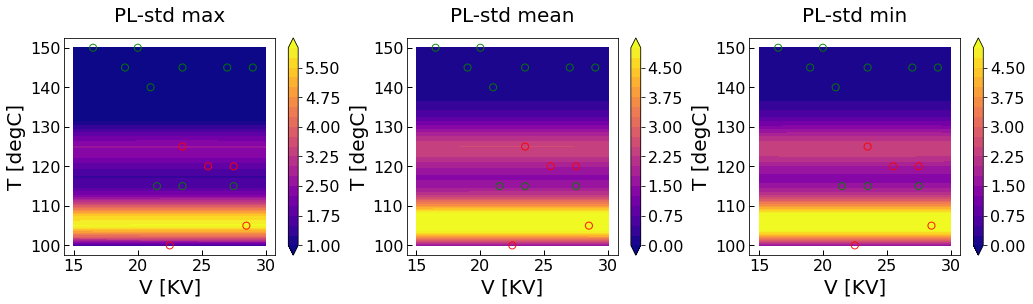

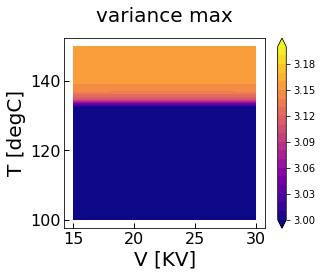

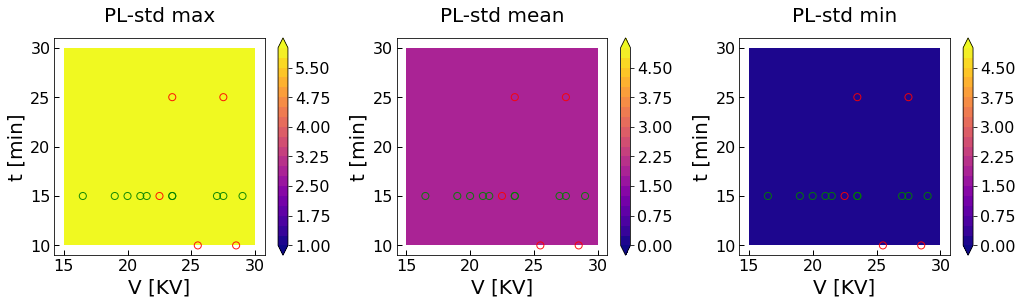

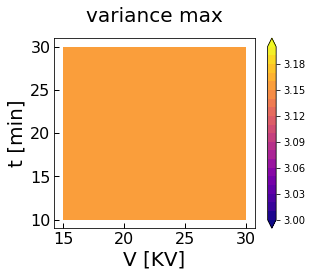

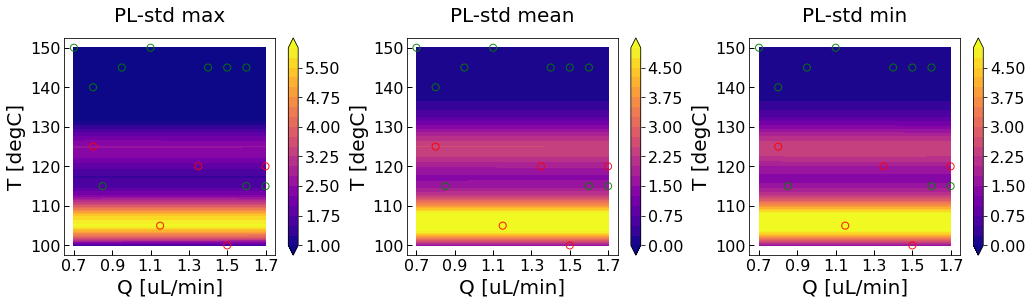

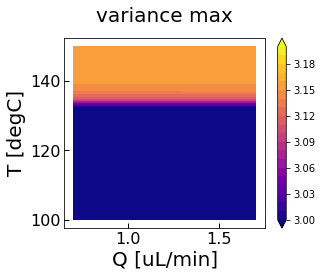

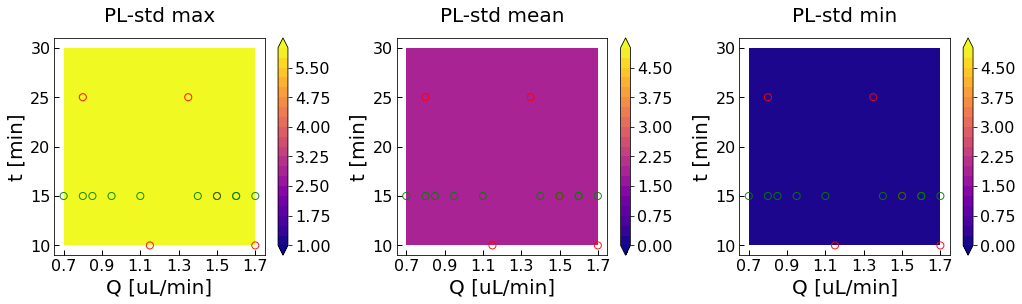

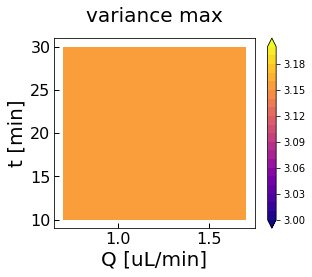

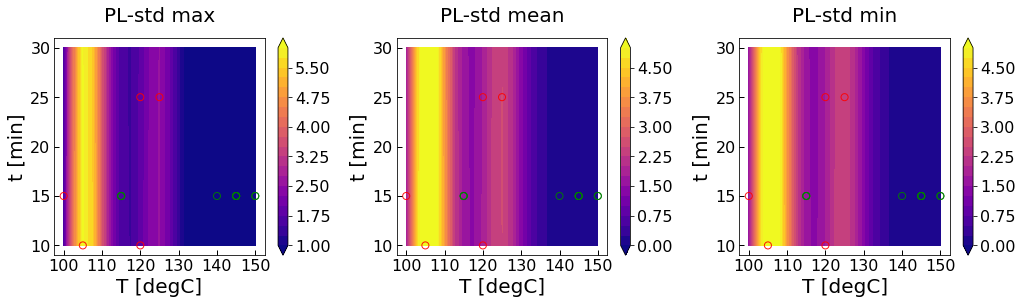

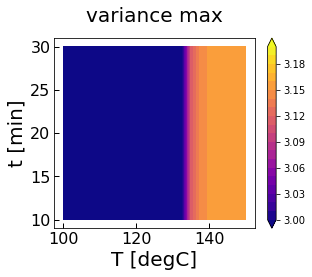

In [44]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_sampled = x_sampled
input_dim = 6
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj3(x_temp)
                y2 = y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y2), np.mean(y2), np.min(y2)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
        
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
            
        y_max2 = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_mean2 = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_min2 = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 20
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         for ax, y in zip(axes,
#                            [y_max2, y_mean2, y_min2]):
#             c_plt1 = ax.contourf(x1, x2, y,cmap='plasma',extend='both')
        colorbar_offset = [1, 0, 0]
        for ax, c_offset, y in zip(axes,colorbar_offset,
                           [y_max2, y_mean2, y_min2]):
            c_plt1 = ax.contourf(x1, x2, y,levels = np.arange(21)*0.25+c_offset,cmap='plasma',extend='both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X3)[:, ind1], 
                       x_denormalizer(X3)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter((X_new)[:, ind1], 
                       (X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            
            ax.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_labels[ind2]),fontsize =  fs)
            
            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
            if ind1==1:#DMF%
                ax.set_xticks([0, 30, 60, 90])
            if ind1==2:#V
                ax.set_xticks([15, 20, 25, 30])
            if ind1==3:#Q
                ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
            if ind1==4:#T
                ax.set_xticks([100, 110, 120, 130, 140, 150])
            if ind1==5:#t
                ax.set_yticks([10, 15, 20, 25, 30])
                
        axes[0].set_title('PL-std max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('PL-std mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('PL-std min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()
        
        fig,axes = plt.subplots(1, 1, figsize=(4.5, 3.5), sharey =False, sharex = False) 
#         c_plt3 = axes.contourf(x1, x2, y_uncer_max, cmap='plasma',extend='both')
        colorbar_offset = [3]
        c_plt3 = axes.contourf(x1, x2, y_uncer_max, levels = np.arange(21)*0.01+colorbar_offset, cmap='plasma',extend='both')
        cbar = fig.colorbar(c_plt3, ax = axes)
        axes.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
        axes.set_ylabel(str(x_labels[ind2]),fontsize =  fs)

        x1_delta = (np.max(x1)-np.min(x1))*0.05
        x2_delta = (np.max(x2)-np.min(x2))*0.05
        axes.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
        axes.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
        axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
        if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
        if ind1==1:#DMF%
            ax.set_xticks([0, 30, 60, 90])
        if ind1==2:#V
            ax.set_xticks([15, 20, 25, 30])
        if ind1==3:#Q
            ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
        if ind1==4:#T
            ax.set_xticks([100, 110, 120, 130, 140, 150])
        if ind1==5:#t
            ax.set_yticks([10, 15, 20, 25, 30])
            
#         axes.scatter(x_denormalizer(X1)[:, 0], 
#                        x_denormalizer(X1)[:, 1], 
#                        s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
        axes.set_title('variance max', pad = title_pad,fontsize =  fs)

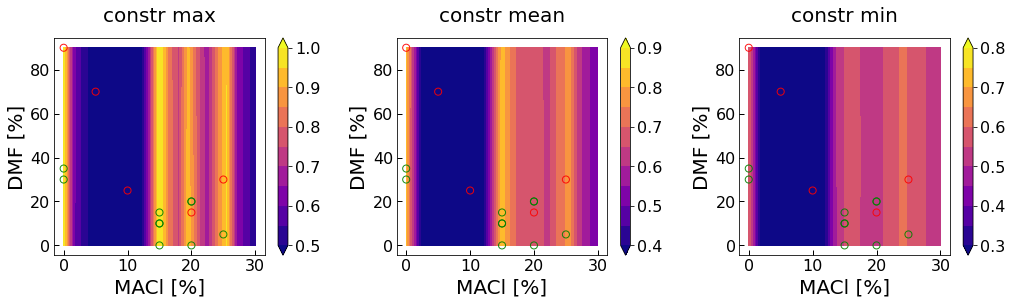

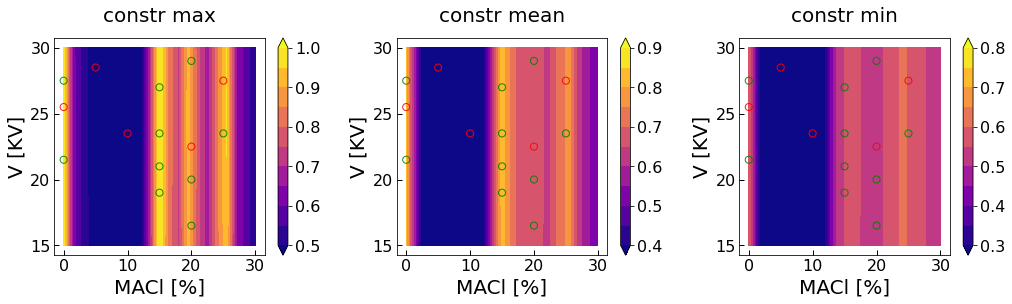

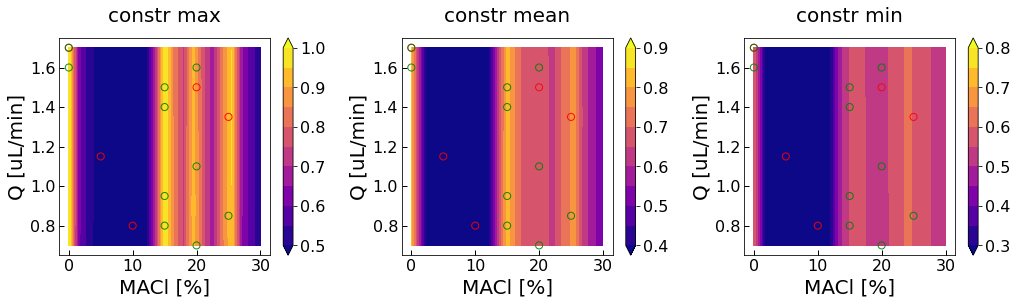

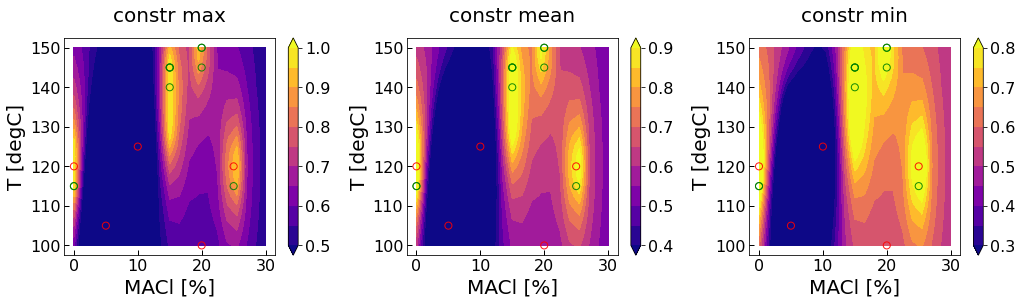

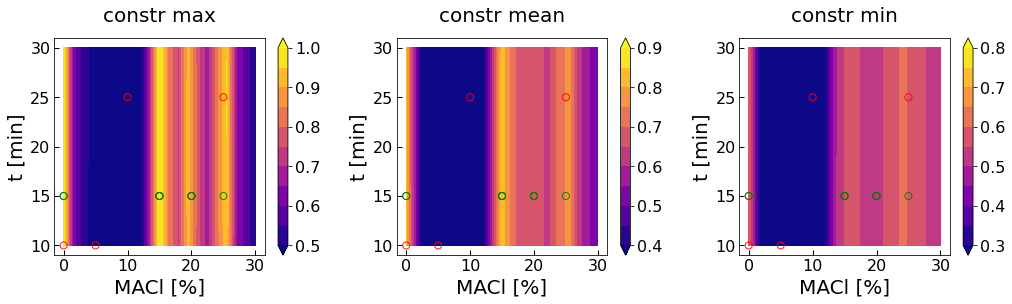

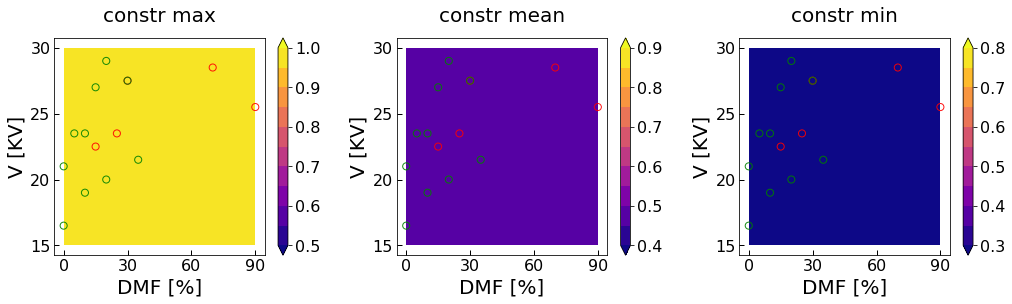

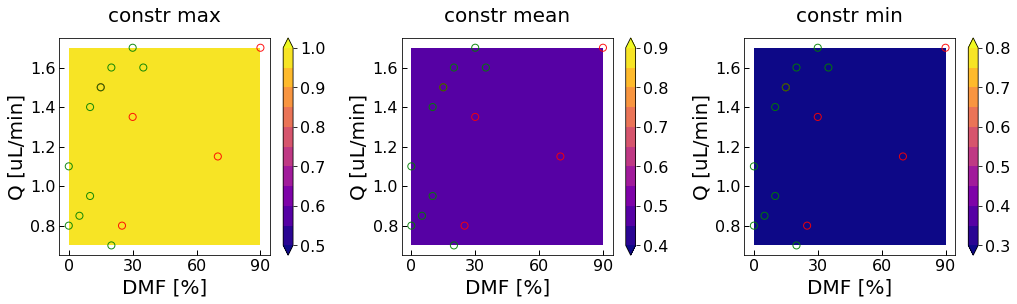

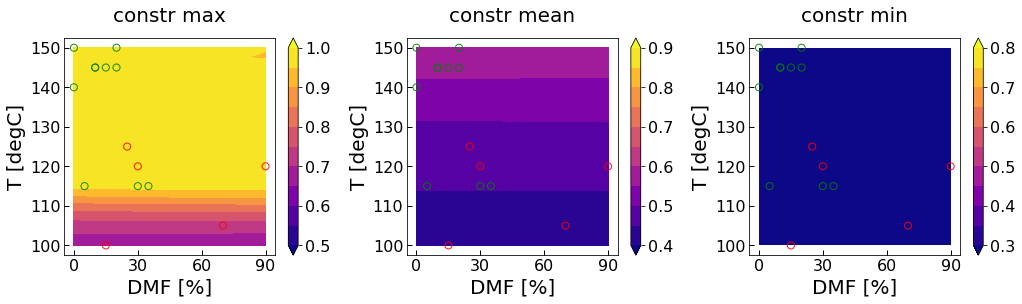

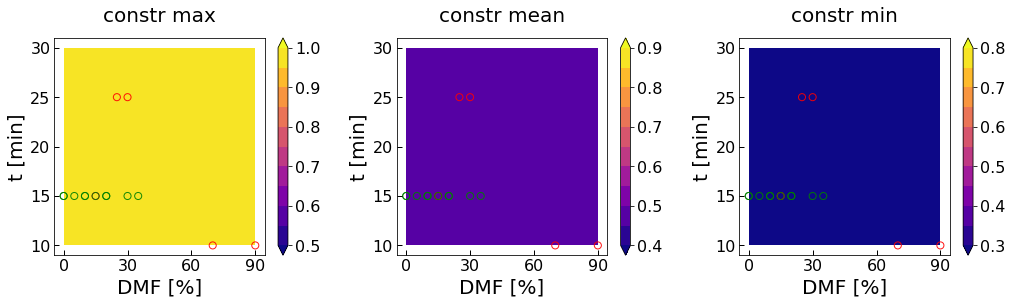

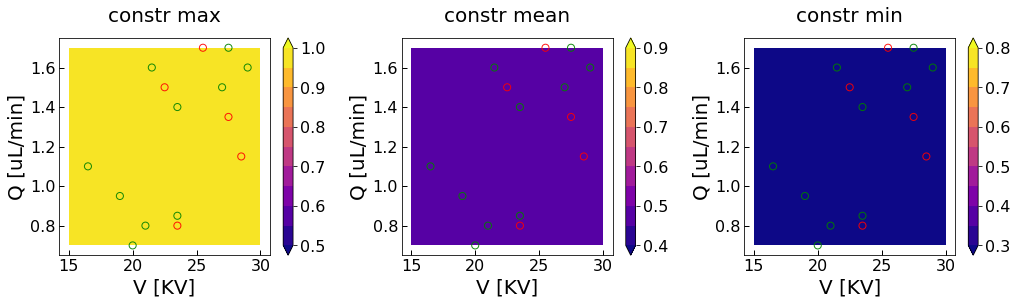

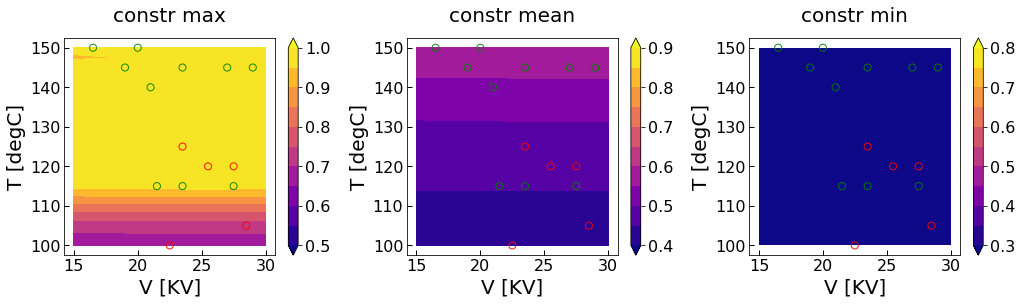

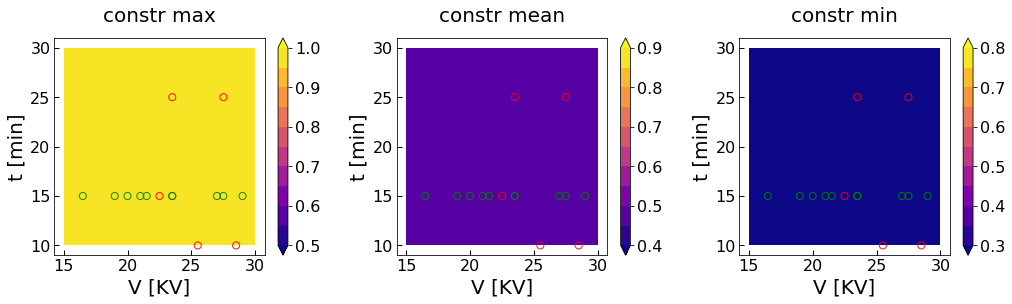

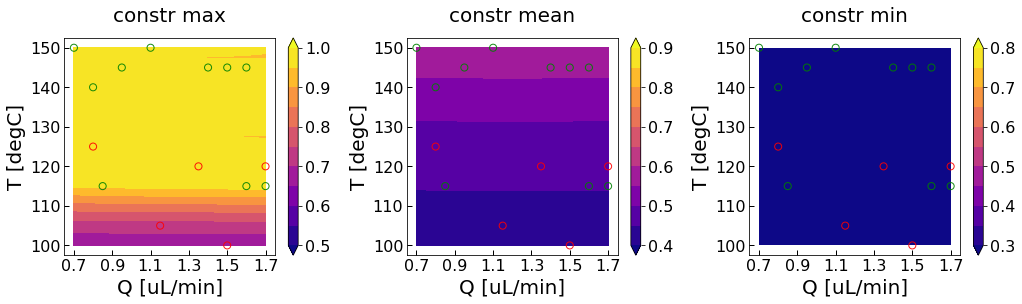

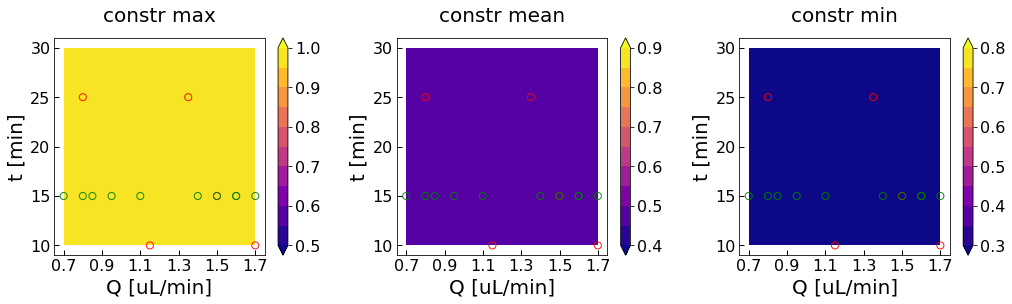

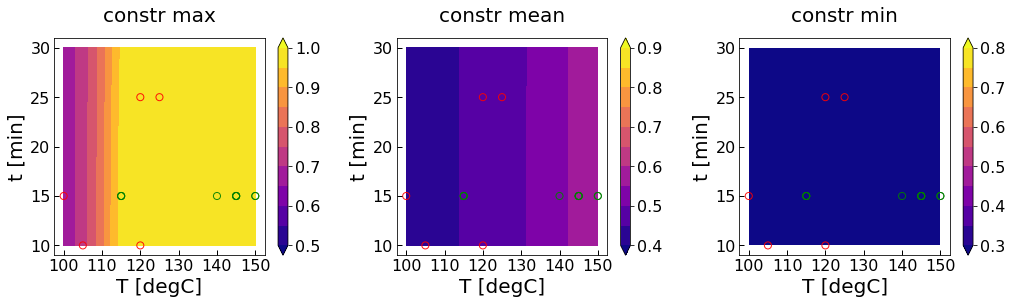

In [38]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_sampled = x_sampled
input_dim = 6
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred = acquisition_constraint.evaluate(x_temp)
                y2 = y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y2), np.mean(y2), np.min(y2)])
        
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
            
        y_max2 = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_mean2 = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_min2 = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
   
        fs = 20
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         for ax, y in zip(axes,
#                            [y_max2, y_mean2, y_min2]):
#             c_plt1 = ax.contourf(x1, x2, y,cmap='plasma',extend='both')
        colorbar_offset = [0.5, 0.4, 0.3]
        for ax, c_offset, y in zip(axes,colorbar_offset,
                           [y_max2, y_mean2, y_min2]):
            c_plt1 = ax.contourf(x1, x2, y,levels = np.arange(11)*0.05+c_offset,cmap='plasma',extend='both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X4)[:, ind1], 
                       x_denormalizer(X4)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter((X_new)[:, ind1], 
                       (X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_labels[ind2]),fontsize =  fs)
            
            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
            if ind1==1:#DMF%
                ax.set_xticks([0, 30, 60, 90])
            if ind1==2:#V
                ax.set_xticks([15, 20, 25, 30])
            if ind1==3:#Q
                ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
            if ind1==4:#T
                ax.set_xticks([100, 110, 120, 130, 140, 150])
            if ind1==5:#t
                ax.set_yticks([10, 15, 20, 25, 30])
                
        axes[0].set_title('constr max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('constr mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('constr min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()

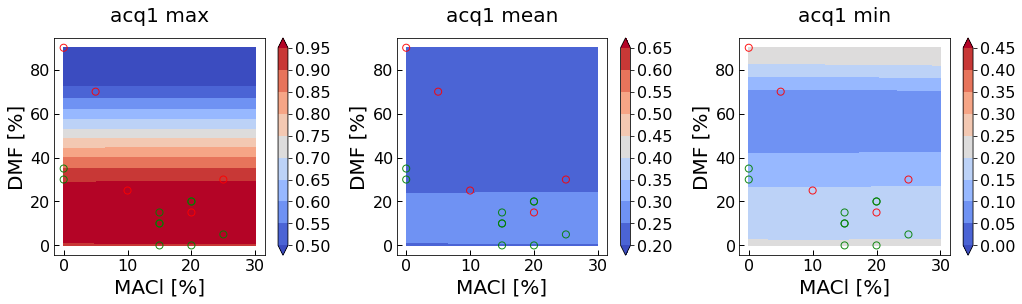

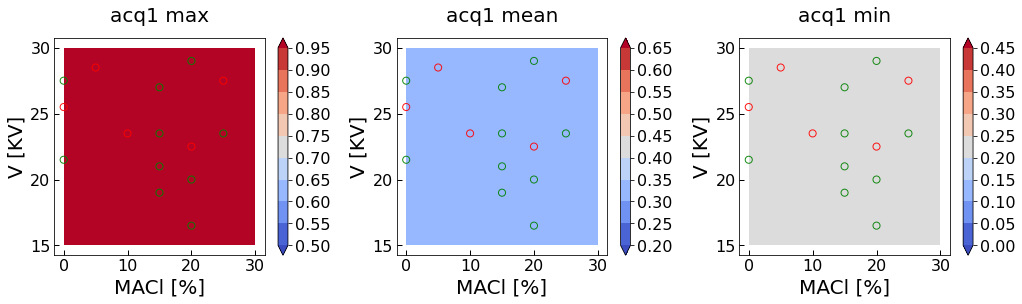

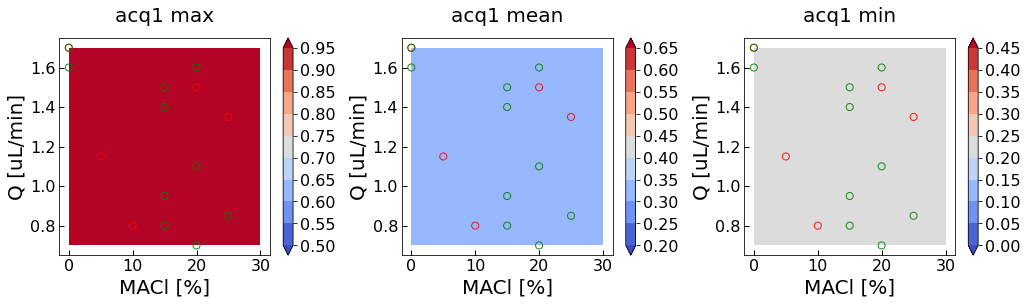

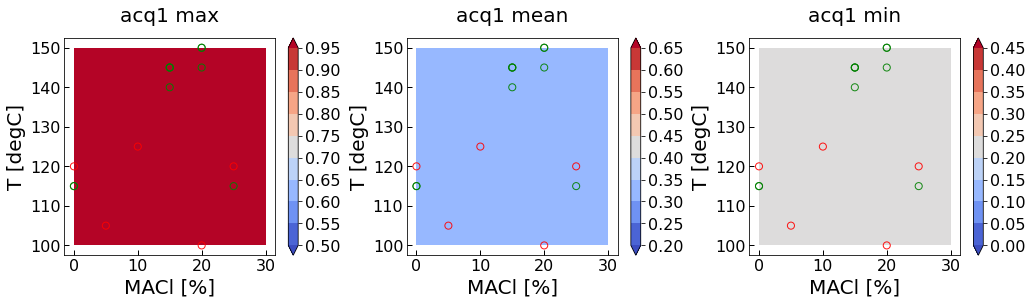

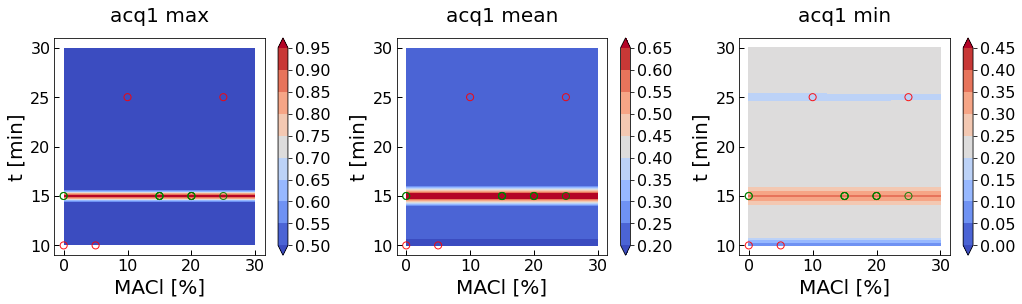

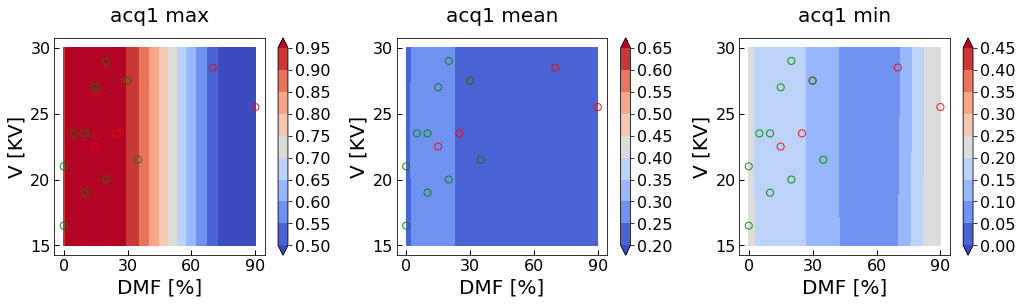

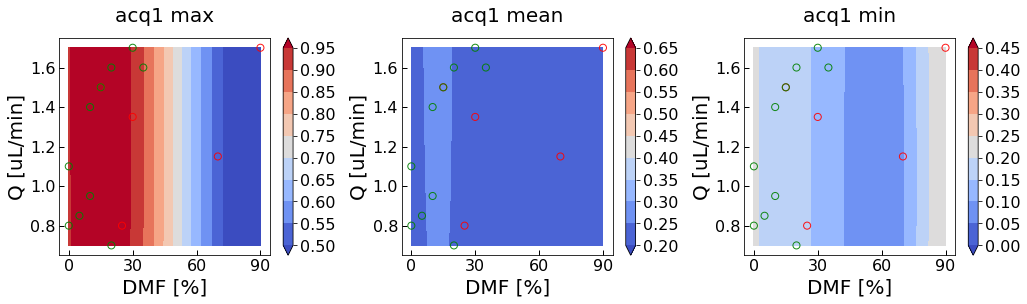

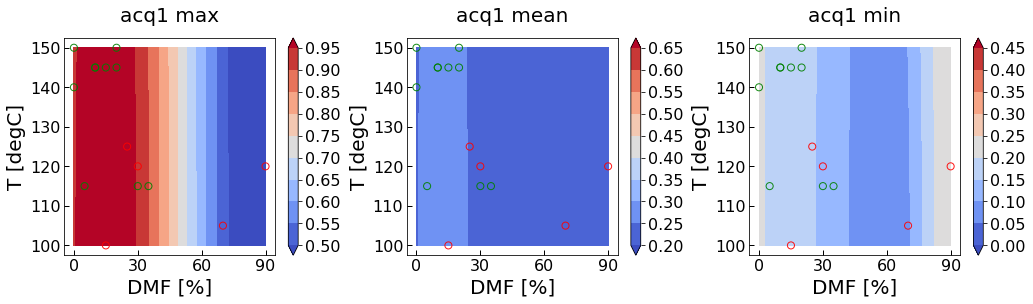

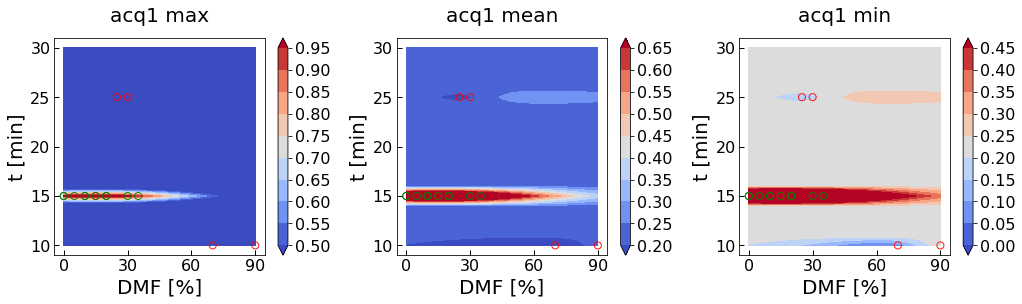

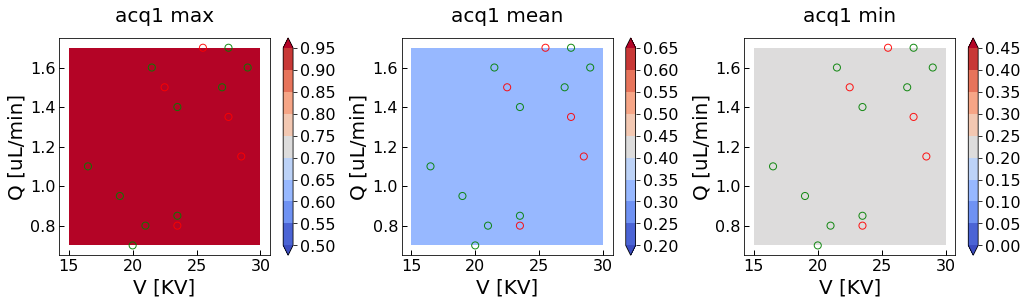

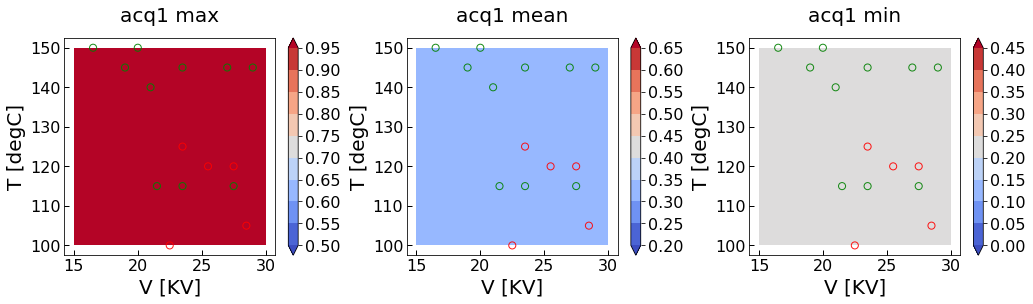

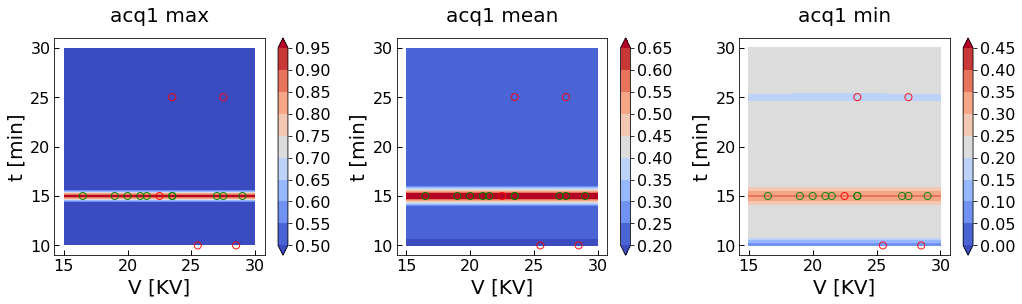

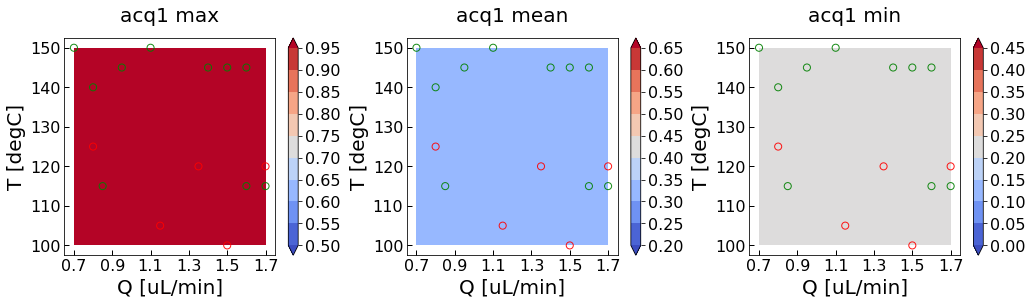

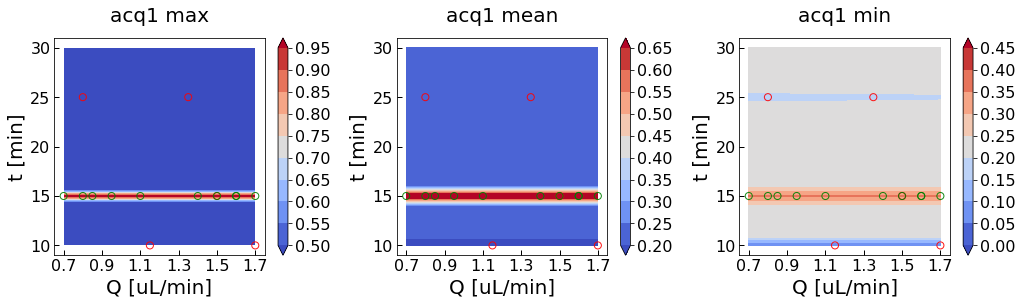

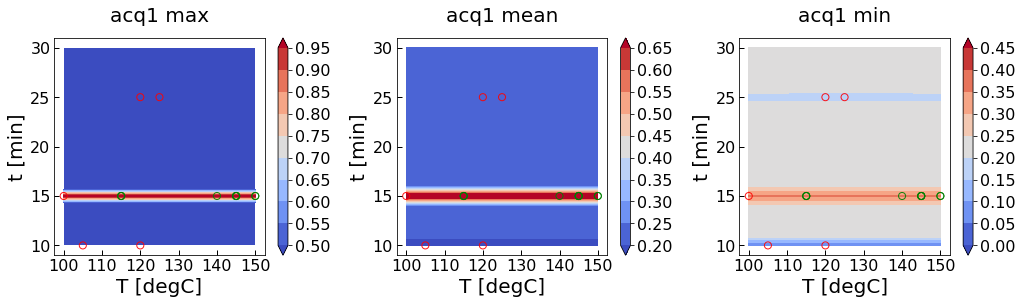

In [48]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_sampled = x_sampled
input_dim = 6
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred = acquisition1.evaluate(x_temp)
                y2 = y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y2), np.mean(y2), np.min(y2)])
        
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
            
        y_max2 = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_mean2 = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_min2 = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
   
        fs = 20
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         for ax, y in zip(axes,
#                            [y_max2, y_mean2, y_min2]):
#             c_plt1 = ax.contourf(x1, x2, y/max(y_max2.flatten()),cmap='coolwarm',extend='both')
        colorbar_offset = [0.5, 0.2, 0]
        for ax, c_offset, y in zip(axes,colorbar_offset,
                           [y_max2, y_mean2, y_min2]):
            c_plt1 = ax.contourf(x1, x2, y/max(y_max2.flatten()),levels =  np.arange(10)*0.05+c_offset,cmap='coolwarm',extend='both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X4)[:, ind1], 
                       x_denormalizer(X4)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter((X_new)[:, ind1], 
                       (X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_labels[ind2]),fontsize =  fs)
            
            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
            if ind1==1:#DMF%
                ax.set_xticks([0, 30, 60, 90])
            if ind1==2:#V
                ax.set_xticks([15, 20, 25, 30])
            if ind1==3:#Q
                ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
            if ind1==4:#T
                ax.set_xticks([100, 110, 120, 130, 140, 150])
            if ind1==5:#t
                ax.set_yticks([10, 15, 20, 25, 30])
                
        axes[0].set_title('acq1 max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('acq1 mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('acq1 min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()

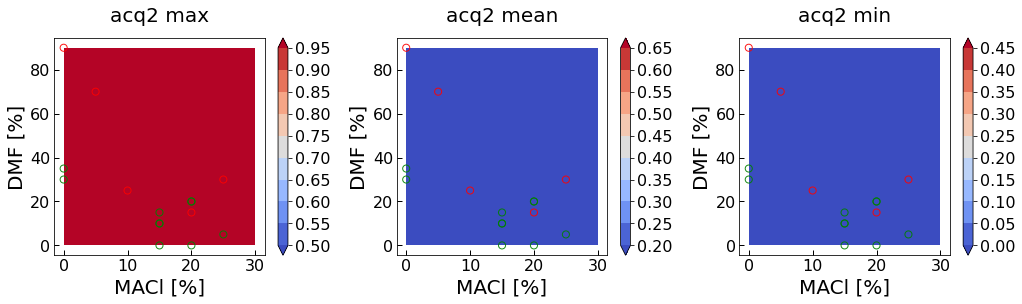

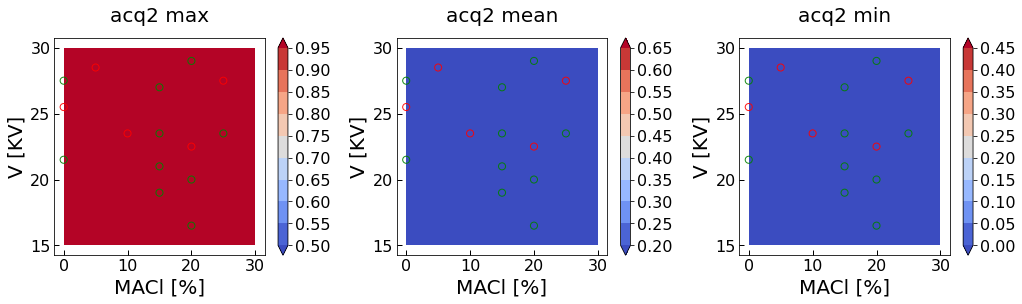

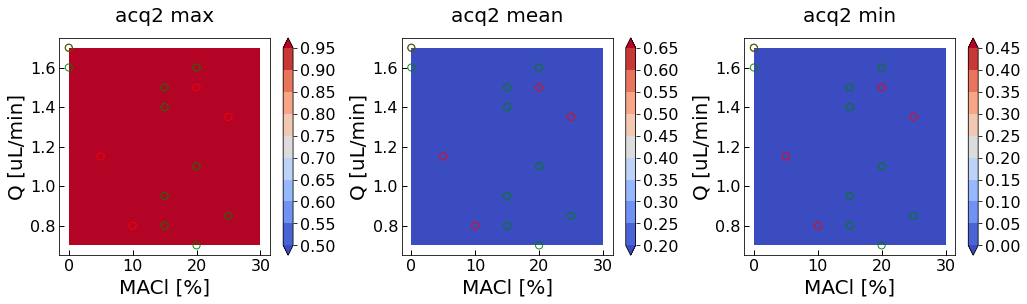

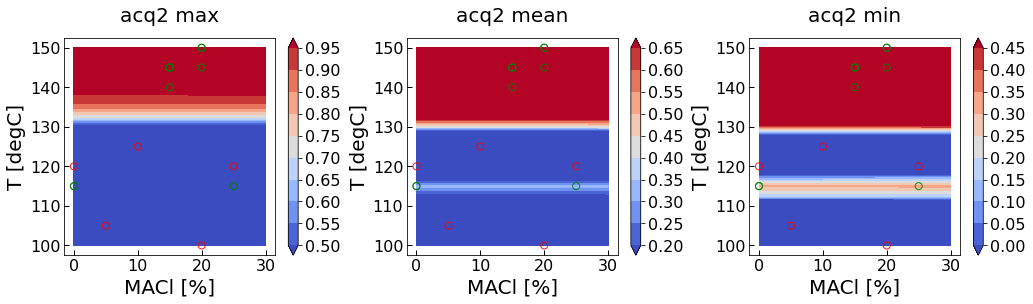

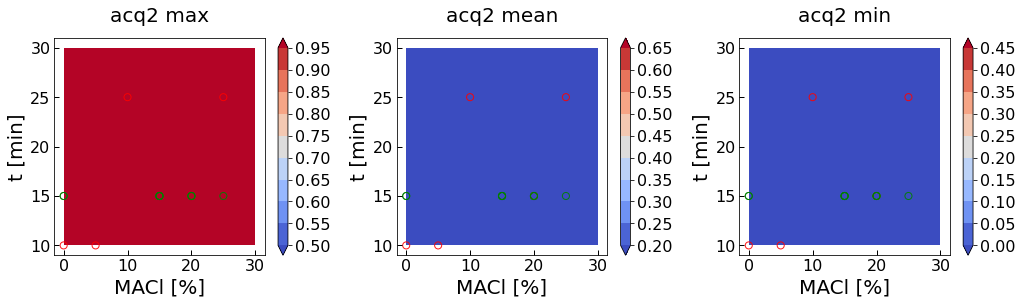

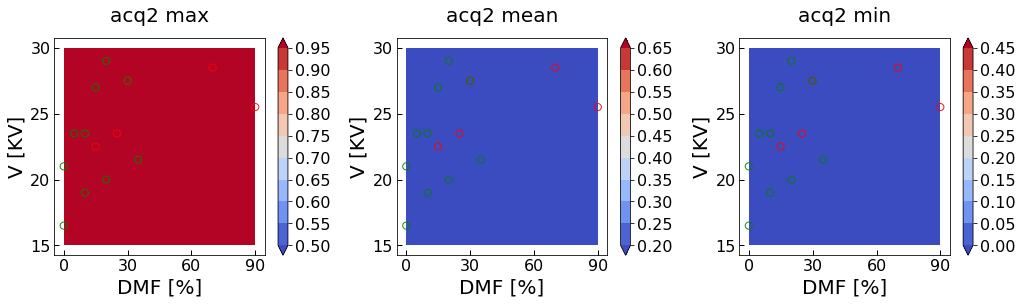

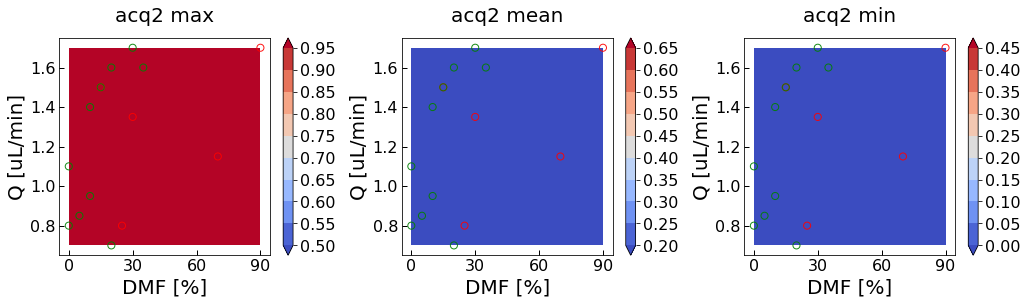

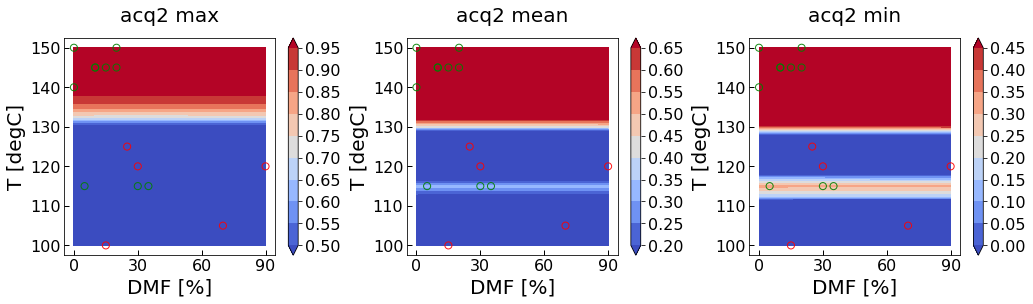

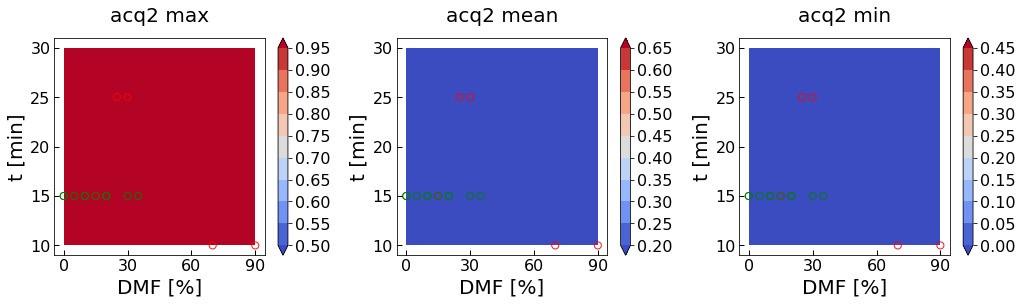

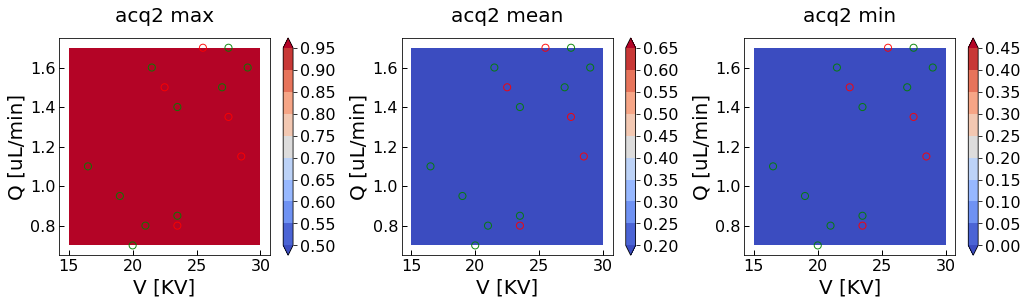

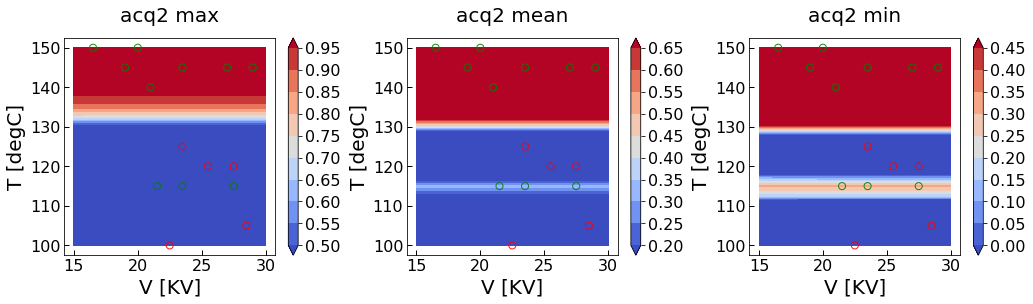

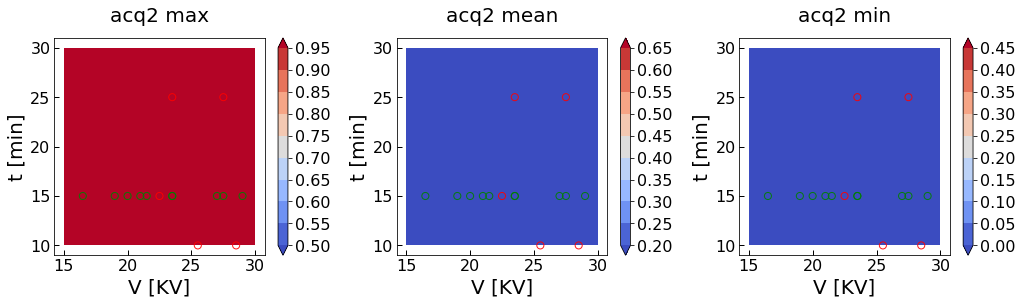

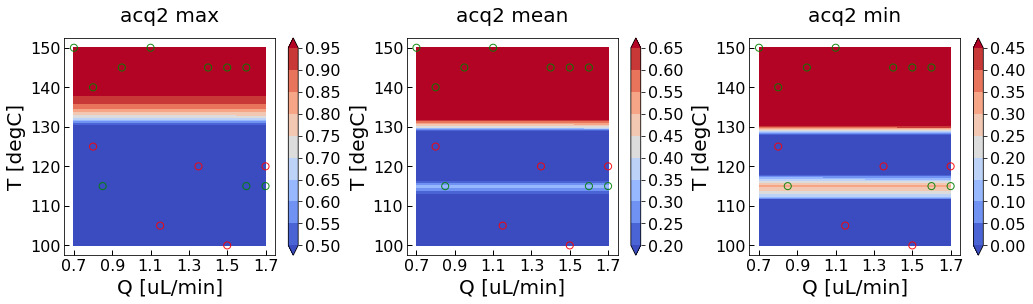

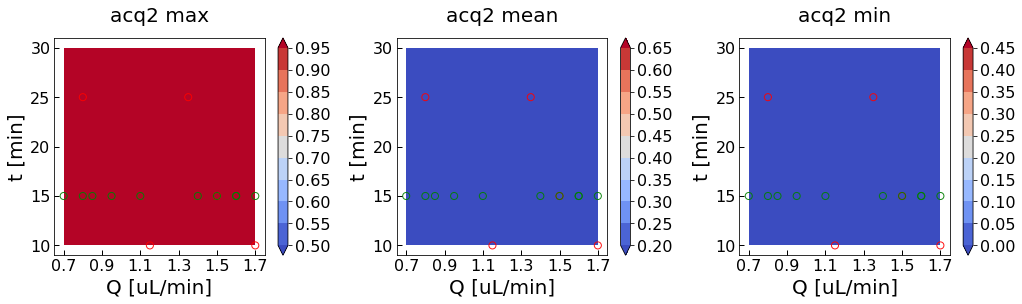

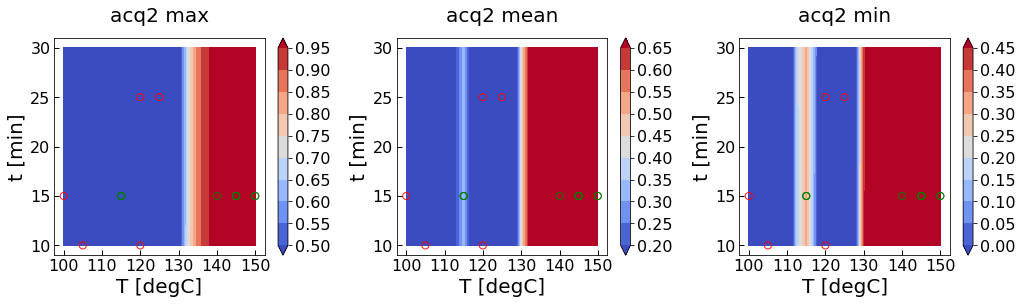

In [49]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_sampled = x_sampled
input_dim = 6
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred = acquisition2.evaluate(x_temp)
                y2 = y_pred
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y2), np.mean(y2), np.min(y2)])
        
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
            
        y_max2 = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_mean2 = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_min2 = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
   
        fs = 20
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
#         for ax, y in zip(axes,
#                            [y_max2, y_mean2, y_min2]):
#             c_plt1 = ax.contourf(x1, x2, y/max(y_max2.flatten()),cmap='coolwarm',extend='both')
        colorbar_offset = [0.5, 0.2, 0]
        for ax, c_offset, y in zip(axes,colorbar_offset,
                           [y_max2, y_mean2, y_min2]):
            c_plt1 = ax.contourf(x1, x2, y/max(y_max2.flatten()),levels =  np.arange(10)*0.05+c_offset,cmap='coolwarm',extend='both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X4)[:, ind1], 
                       x_denormalizer(X4)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.scatter((X_new)[:, ind1], 
                       (X_new)[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_labels[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_labels[ind2]),fontsize =  fs)
            
            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MACl%
                ax.set_xticks([0, 10, 20, 30])
            if ind1==1:#DMF%
                ax.set_xticks([0, 30, 60, 90])
            if ind1==2:#V
                ax.set_xticks([15, 20, 25, 30])
            if ind1==3:#Q
                ax.set_xticks([0.7, 0.9, 1.1, 1.3, 1.5, 1.7])
            if ind1==4:#T
                ax.set_xticks([100, 110, 120, 130, 140, 150])
            if ind1==5:#t
                ax.set_yticks([10, 15, 20, 25, 30])
                
        axes[0].set_title('acq2 max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('acq2 mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('acq2 min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()